In [106]:
import pandas as pd
import os, re 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import seaborn as sns 

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.decomposition import PCA
from numpy.linalg import svd 

#PERMANOVA on SV1/SV2 sample projections of data 
from scipy.spatial import distance_matrix
from skbio.stats import distance as sk_distance 

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [107]:
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAXA_NAMES = ["B. breve","B. catenulatum","B. longum infantis 2D9","B. luti","B. obeum","D. formicigenerans",
                     "D. longicatena","E. avium","E. coli","F. prausnitzii","L. garvieae","L. ruminis",
                     "M. multacida","P. copri","P. stercorea","R. gnavus","R. torques","S. gallolyticus","S. pasteurianus"]

In [108]:
#Workspace set-up - data loading, figure directory configuration, final processing of dataset (these steps now 
#done earlier in workflow to subset to cecal contents and remove prevotella species)


DATA_FILTERING = "edgeR"
# DATA_FILTERING = "tpm_prev"

###========###
#Non-rlog filtered (ie tpm/prev)
###========###
if DATA_FILTERING == "tpm_prev":
    DATASET = "rlog"
    ABUNDANCE_CORRECTED_DATA = True

    if ABUNDANCE_CORRECTED_DATA:
#         PARAM_STR = "thr3_prev0.25_cecal_nonprevotella_E6"
        PARAM_STR = "thr3_prev0.25_cecal_nonprevotella_E6_floor"
        figures_dir = "figures/4th_trial/{0}/SVD_{1}".format(PARAM_STR,DATASET)
        bpm_filt_data_path = "formatted_output/4th_trial/bpm_filtered_abundance_corrected/{0}".format(PARAM_STR) 
        lsv_tables_dir = "formatted_output/4th_trial/lsv_tables/abundance_corrected/{0}".format(PARAM_STR) 
        fp_tables_dir = "formatted_output/4th_trial/fp_tables/abundance_corrected/{0}".format(PARAM_STR)
    else: 
        PARAM_STR = "thr3_prev0.3_cecal_nonprevotella"
        figures_dir = "figures/4th_trial/{0}/SVD_{1}".format(PARAM_STR,DATASET)
        bpm_filt_data_path = "formatted_output/4th_trial/bpm_filtered/{0}".format(PARAM_STR) 
        lsv_tables_dir = "formatted_output/4th_trial/lsv_tables/uncorrected/{0}".format(PARAM_STR) 
        fp_tables_dir = "formatted_output/4th_trial/fp_tables/uncorrected/{0}".format(PARAM_STR)
elif DATA_FILTERING == "edgeR":
    DATASET = "rlog"
    PARAM_STR = "edgeR_filtered"
    
    figures_dir = "figures/4th_trial/edgeR_filtered/SVD_{0}".format(DATASET)
    bpm_filt_data_path = "formatted_output/4th_trial/edgeR_filtered"
    lsv_tables_dir = "formatted_output/4th_trial/lsv_tables/edgeR_filtered"
    fp_tables_dir = "formatted_output/4th_trial/fp_tables/edgeR_filtered"

if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
if not os.path.exists(lsv_tables_dir):
    os.makedirs(lsv_tables_dir)
if not os.path.exists(fp_tables_dir):
    os.makedirs(fp_tables_dir)

In [109]:



bpm_filt_expr_fpath = "{0}/bpm_filt_{1}.csv".format(bpm_filt_data_path,DATASET)
# bpm_filt_expr_fpath = "{0}/mystery.csv".format(bpm_filt_data_path,DATASET)
pht_agg_expr_fpath = "{0}/bpm1_agg_pht_{1}.csv".format(bpm_filt_data_path,DATASET)
condensed_agg_expr_fpath = "{0}/condensed_agg_pht_{1}.csv".format(bpm_filt_data_path,DATASET)

bpm_filt_expr_df = pd.read_csv(bpm_filt_expr_fpath,index_col=0)
bpm_filt_expr_df.drop_duplicates(inplace=True)
pht_agg_expr_df = pd.read_csv(pht_agg_expr_fpath,index_col=0)
condensed_agg_expr_df = pd.read_csv(condensed_agg_expr_fpath,index_col=0)
SHOW_PRE_FILTERED = False
if SHOW_PRE_FILTERED:
    print("Pre-filtering:")
    display(bpm_filt_expr_df)
    display(condensed_agg_expr_df)

#Cecal contents only filtering 
cecal_filter = True 
if cecal_filter:
    cecal_bpm_filt_expr_df = bpm_filt_expr_df.loc[:,bpm_filt_expr_df.columns.str.contains("cecal")]
    bpm_filt_expr_df = cecal_bpm_filt_expr_df
    
    cecal_condensed_agg_df = condensed_agg_expr_df.loc[:,condensed_agg_expr_df.columns.str.contains("cecal")]
    condensed_agg_expr_df = cecal_condensed_agg_df

drop_prevotella = True 
if drop_prevotella:
    bpm_filt_expr_df = bpm_filt_expr_df.loc[~bpm_filt_expr_df.index.str.contains(r'NBCBLOMG|NJCFFJJN'),:]
    condensed_agg_expr_df = condensed_agg_expr_df.loc[~condensed_agg_expr_df.index.str.contains(r'Pst|Pco'),:]


feature_center = True
if feature_center:
    bpm_filt_expr_df = bpm_filt_expr_df.subtract(bpm_filt_expr_df.mean(axis=1),axis=0)
    condensed_agg_expr_df = condensed_agg_expr_df.subtract(condensed_agg_expr_df.mean(axis=1),axis=0)
    
assert(np.isclose(bpm_filt_expr_df.mean(axis=1).sum(),0))
assert(np.isclose(condensed_agg_expr_df.mean(axis=1).sum(),0))

#Convert so that samples are rows, features are columns (ie tranpose of previous data format)
data_tranpose = True 
if data_tranpose:
    if not bpm_filt_expr_df.index.str.contains("cecal").sum():
        bpm_filt_expr_df = bpm_filt_expr_df.transpose()
    if not condensed_agg_expr_df.index.str.contains("cecal").sum():
        condensed_agg_expr_df = condensed_agg_expr_df.transpose()
print("Post Filtering/Transpose")
display(bpm_filt_expr_df)
display(condensed_agg_expr_df)
        
        
# print("==BPM=1 Transcripts STD==")        
# display(bpm_filt_expr_df.std(axis=0))
# print("==BPM=1 Phenotypes STD==")        
# display(condensed_agg_expr_df.std(axis=0))

Post Filtering/Transpose


,ANCJAENF_00282,ANCJAENF_00283,ANCJAENF_00439,ANCJAENF_00597,ANCJAENF_00670,ANCJAENF_00671,ANCJAENF_00674,ANCJAENF_00675,ANCJAENF_01124,ANCJAENF_01125,...,LDOIJNDB_00908,LDOIJNDB_00635,LDOIJNDB_02060,LDOIJNDB_01022,LDOIJNDB_01273,LDOIJNDB_01683,LDOIJNDB_01949,LDOIJNDB_00521,LDOIJNDB_01036,LDOIJNDB_00003
Pup_1.cecal_contents_53_1C_Pup_1,0.645476,1.203773,0.592745,0.654611,1.065859,0.067464,1.325362,1.228259,0.803582,0.134522,...,1.193725,0.089448,0.977463,-0.295207,0.112794,0.517103,0.094709,-0.182056,-0.134223,-0.183694
Pup_2.cecal_contents_53_1C_Pup_2,-0.510403,1.017364,0.395397,-0.544479,1.323022,0.676250,0.103072,0.651657,0.007233,-0.376016,...,-0.098172,0.009605,0.081966,0.242443,-0.043002,0.083306,-0.068338,0.397959,0.576163,0.260048
Pup_3.cecal_contents_53_1C_Pup_3,0.816128,1.091722,0.514797,0.658938,0.757483,0.314333,1.307460,1.359136,0.692353,-0.012195,...,0.060068,0.416387,0.840454,0.261706,0.577642,1.641431,0.246335,0.307246,0.190730,0.720984
Pup_4.cecal_contents_53_1C_Pup_4,0.540118,0.617514,0.764186,0.868497,0.598747,-0.500332,0.891076,0.900794,0.856717,0.407944,...,0.125230,-0.034158,-0.653994,0.161774,-0.494005,-0.000162,0.341939,1.283218,0.706308,0.759009
Pup_5.cecal_contents_53_1C_Pup_5,0.103862,0.419160,0.036627,0.161211,0.256402,-0.224724,0.248925,0.281495,0.147565,-0.328571,...,-0.849022,-0.375611,-0.302955,-0.533356,-0.413483,-0.202547,-0.616154,-0.019712,-0.177961,-0.461675
Pup_6.cecal_contents_53_1C_Pup_6,1.767947,1.096755,-0.130632,-0.291266,-0.153086,0.424409,0.816335,-0.000490,-0.825823,-0.751450,...,-1.646488,-1.206491,-1.881908,-0.678527,-1.538976,-0.586026,-1.033606,0.140491,-0.225930,-0.435878
Pup_7.cecal_contents_53_1C_Pup_7,0.380273,0.830883,0.435300,0.500925,0.634005,-0.372340,0.519398,0.749000,0.350777,-0.254795,...,0.274950,0.086249,0.241586,-0.192798,-0.125987,0.283177,-0.628866,0.070469,0.082138,0.125898
Pup_8.cecal_contents_53_1C_Pup_8,0.059305,0.450066,0.316447,0.152485,1.869758,1.799121,0.979158,0.837719,0.390904,-0.053969,...,-0.041586,0.283986,0.350316,0.091495,0.206475,0.190673,-0.275098,-0.223174,-0.148330,0.149600
Pup_1.cecal_contents_54_2B_Pup_1,-0.347905,2.071513,0.461227,0.663050,-0.115661,1.293039,1.881777,1.853027,1.893892,0.259639,...,1.188796,0.674302,0.953265,1.158217,0.859188,1.597232,1.096300,1.178221,1.143192,0.617334
Pup_2.cecal_contents_54_2B_Pup_2,2.666885,-4.040568,-0.093505,1.746712,-4.082877,-3.803246,-4.107643,-4.013408,-4.273318,1.902802,...,-3.102297,-0.328467,-0.427921,-0.899870,-0.154447,-3.561035,-0.537118,-1.407304,-1.928820,-1.111716


,Bbr_Glc,Bbr_Fru,Bbr_NANA,Bbr_Fuc,Bbr_Rbs,Bbr_Mal,Bbr_Scr,Bbr_Lnb,Bbr_Lac,Bbr_Mtl,...,Spa_Asn,Spa_B2,Spa_B3,Spa_B9,Spa_Q,Spa_Acetate,Spa_Formate,Spa_L-Lactate,Spa_Ethanol,Spa_CA_d
Pup_1.cecal_contents_53_1C_Pup_1,0.774151,0.745643,1.148047,0.653869,1.298412,0.593423,0.149074,0.928807,0.991723,1.065859,...,0.636783,0.056582,0.061721,0.665239,0.647966,0.533456,-0.091206,0.305906,-0.166111,-0.183694
Pup_2.cecal_contents_53_1C_Pup_2,0.089470,0.626558,0.823265,-0.119468,1.359600,-0.033302,0.263236,-0.405376,0.925766,1.323022,...,-0.613090,-0.161203,-0.287839,-0.895850,-0.011640,0.045786,0.099720,0.007484,0.457360,0.260048
Pup_3.cecal_contents_53_1C_Pup_3,0.770396,0.744917,1.140429,0.663267,1.359647,0.343074,0.180477,0.886183,0.754243,0.757483,...,0.537130,0.350681,0.656529,0.761327,0.169070,0.628420,0.419674,0.943883,0.268407,0.720984
Pup_4.cecal_contents_53_1C_Pup_4,0.697579,0.314012,1.540885,0.856098,1.250749,0.662057,0.841604,0.849307,1.156604,0.598747,...,-0.522497,-0.227139,-0.486841,-0.760810,0.319733,-0.344076,-0.166116,0.170889,1.090915,0.759009
Pup_5.cecal_contents_53_1C_Pup_5,0.180215,0.138675,0.792264,-0.192137,0.737465,-0.086379,0.089790,0.122726,0.404889,0.256402,...,0.015325,-0.293103,0.062002,-0.514334,-0.779317,-0.339283,-0.473420,-0.409350,-0.072461,-0.461675
Pup_6.cecal_contents_53_1C_Pup_6,0.610701,0.784006,1.160682,-0.063909,-0.440019,-0.093524,-0.429770,0.285375,0.380090,-0.153086,...,-1.745909,-1.080147,-1.426315,-0.612625,-1.453388,-1.544200,-1.108751,-0.809816,0.018351,-0.435878
Pup_7.cecal_contents_53_1C_Pup_7,0.536845,0.368205,1.885754,0.477120,1.275741,0.380352,-0.089212,0.561672,0.556707,0.634005,...,-0.385919,0.450316,-0.016940,-0.179103,0.033951,0.163918,-0.159393,-0.172845,0.074359,0.125898
Pup_8.cecal_contents_53_1C_Pup_8,0.244576,1.044563,-1.044646,1.122864,0.648383,0.825749,0.993841,0.477379,0.496035,1.869758,...,0.136487,0.049284,-0.138475,0.202923,0.150318,0.317151,0.148985,-0.042213,-0.198226,0.149600
Pup_1.cecal_contents_54_2B_Pup_1,0.711971,0.725246,-0.358228,0.331106,1.897481,0.513407,0.701092,1.283315,2.489325,-0.115661,...,1.422879,1.235789,1.187973,1.006031,0.688254,0.813784,1.008703,1.346766,1.166545,0.617334
Pup_2.cecal_contents_54_2B_Pup_2,0.069881,-2.314952,-3.002400,-1.441024,-3.904867,-1.516103,-2.671776,-2.440378,-2.384229,-4.082877,...,-0.364496,-0.790153,-0.263621,-0.548245,-1.433818,-0.378194,-0.527159,-2.049076,-1.581143,-1.111716


In [110]:
# Sanity check for locus inclusion 
# display(bpm_filt_expr_df["HIAFFLEM_01096"])

select_phts = ["Rob_Xyl","Rob_Ara","Rob_Gln","Rob_Acetate","Mmu_Ara","Mmu_Glu","Mmu_Leu"]
select_phts_df = condensed_agg_expr_df[select_phts]

display(select_phts_df.iloc[:8,:].mean())
display(select_phts_df.iloc[8:,:].mean())
# display(condensed_agg_expr_df["Rob_Leu"])


Rob_Xyl        2.577767
Rob_Ara        2.898745
Rob_Gln        2.739564
Rob_Acetate    2.551773
Mmu_Ara        2.750917
Mmu_Glu        1.978203
Mmu_Leu        2.400913
dtype: float64

Rob_Xyl       -2.946019
Rob_Ara       -3.312851
Rob_Gln       -3.130930
Rob_Acetate   -2.916313
Mmu_Ara       -3.143905
Mmu_Glu       -2.260804
Mmu_Leu       -2.743900
dtype: float64

From np.linalag.svd:
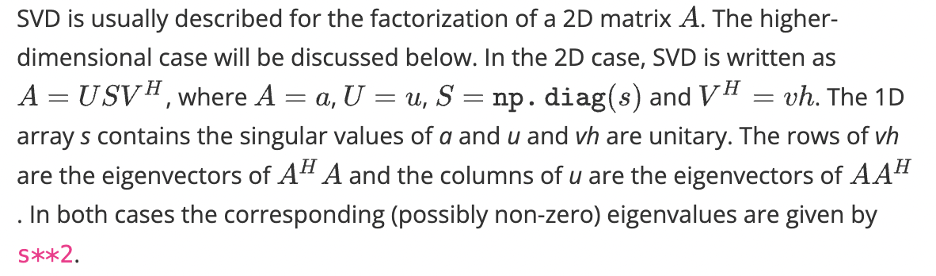

In [111]:
def sv_projections(feature_df,u,s,vh,pc_indices=[0,1],axis=0):
    """Return projections of feature_df onto singular vectors specified by axis 
        feature_df: samples (index) x features (columns)
        u: Matrix of left singular vectors (columns) - n_samples x n_samples
        s: singular values (vector) 
        vh: Matrix of right singular vectors (columns) - n_features x n_features
        pc_indices: list-like of indicies for which singular vectors to generate projections on  
        axis: 0 or 1, for generating sample projections or feature projections respectively 
    """
    #Generate PCs, a len(pc_indices) x {n_samples or n_features} ndarray representing the PCs specified 
    #by pc_indices and axis
    if axis == 0: #sample projections 
        SVs = vh[pc_indices,:]# n_PCs x n_features 
        data = feature_df.values.transpose() #n_features x n_samples
        assert(SVs.shape[1] == data.shape[0])
    elif axis == 1: #feature projections
        SVs = u[:,pc_indices].transpose() #n_PCs x n_samples
        data = feature_df.values #n_samples x n_features 
        assert(SVs.shape[1] == data.shape[0])
    else: 
        raise ValueError("axis must be 0 (sample projections) or 1 (feature projections)")
    #projections = PCs * data
    projections = np.dot(SVs,data)
    return projections
    
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def sig_str_from_pval(pval):
    if pval < 0.0001: 
        sig_str = "****"
    elif pval < 0.001: 
        sig_str = "***"
    elif pval < 0.01: 
        sig_str = "**"
    elif pval < 0.05: 
        sig_str = "*"
    else:
        sig_str = "ns"
    return sig_str

def standardize_plot_style(ax,xlabel,ylabel,title,legend_labels=[],title_size=16,ax_label_size=14,legend_cols=1,
                          legend_title=""):
    ticklabels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight("bold") for label in ticklabels]
    ax.set_xlabel(xlabel,weight="bold",fontsize=ax_label_size)
    ax.set_ylabel(ylabel,weight="bold",fontsize=ax_label_size)
    
    handles,labels = ax.get_legend_handles_labels()
    if len(legend_labels) > 0:
        ax.legend(handles,legend_labels,loc="best",title=legend_title)
    else:
        ax.legend(handles,labels,loc="best",title=legend_title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1),ncol=legend_cols)
    ax.set_title(title,weight="bold",fontsize=title_size)

Permanova p-value: 0.000130
Permanova p-value: 0.000200


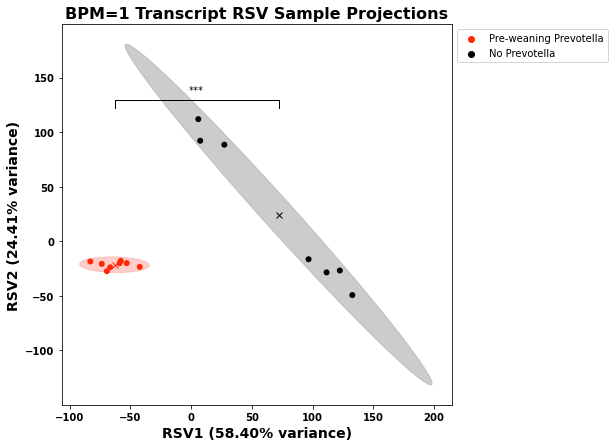

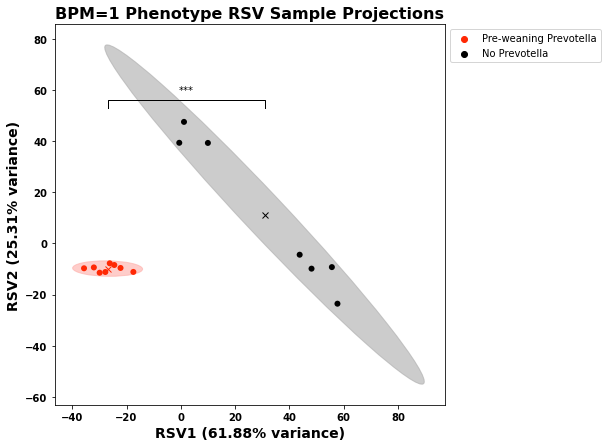

In [112]:
def sample_projections_scatter(expr_df, pc_indices,sample_arm_re=r'[\w_]+\.[\w_]+_([12][ABC])_[\w+]',title_str="",
                              figure_fpath="",arm_labels=["Pre-weaning Prevotella","No Prevotella"]): 
    #Palettes 
    HWDC_points_palette = ["#FF2804","#000000"]
    HWDC_ellipses_palette = ["#FEACA7","#AAAAAA"]
    
    #SVD, explained variance calculations 
    u,s,vh = svd(expr_df)
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    
    #Sample projections
    pc_indices = [0,1]
    sample_projections = sv_projections(expr_df,u,s,vh,pc_indices=pc_indices)
    sample_proj_df = pd.DataFrame(data=sample_projections.T,columns=["RSV1","RSV2"])
    sample_proj_df.loc[:,"Arm"] = expr_df.index.str.extract(sample_arm_re)
    
    v1 = sample_projections.T #M vectors in K dimensions = n_samples x n_PCs
    #permanova requires a skbio.stats.distance.DistanceMatrix object, must convert output  
    sp_dm = sk_distance.DistanceMatrix(distance_matrix(v1,v1,p=2))

    skpa = sk_distance.permanova(distance_matrix=sp_dm,grouping=sample_proj_df["Arm"],permutations=100000)
    skpa_p = skpa["p-value"]
    sig_str = sig_str_from_pval(skpa_p)
    print("Permanova p-value: {:.6f}".format(skpa_p))
    #Scatter plot of sampel projections using 
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    point_palette=HWDC_points_palette
    ellipses_palette = HWDC_ellipses_palette
    sns.scatterplot(data=sample_proj_df,x="RSV1",y="RSV2",hue="Arm",palette=point_palette,zorder=1,linewidth=0)
    
    #Get sample projections subsetted by arm (1C vs 2B), as well as cluster centers for arm
    sample_proj_1C = sample_proj_df.loc[sample_proj_df["Arm"] == "1C",:]
    center_1C_x, center_1C_y = np.mean(sample_proj_1C["RSV1"]),np.mean(sample_proj_1C["RSV2"])
    sample_proj_2B  = sample_proj_df.loc[sample_proj_df["Arm"] == "2B",:]
    center_2B_x, center_2B_y = np.mean(sample_proj_2B["RSV1"]),np.mean(sample_proj_2B["RSV2"])
    #Cluster center markers 
    ax.plot(center_1C_x,center_1C_y,c=point_palette[0],marker='x')
    ax.plot(center_2B_x,center_2B_y,c=point_palette[1],marker='x')
    #Confidence ellipses around each cluster - TODO: adjust n_std to correspond to 95% confidence in 2D (1D equiv of .975)
    ellipse1_c, ellipse2_c = ellipses_palette
    confidence_ellipse(x=sample_proj_1C["RSV1"],y=sample_proj_1C["RSV2"],ax=ax,n_std=2.25,
                       edgecolor=ellipse1_c,facecolor=ellipse1_c,alpha=0.6,zorder=0)
    confidence_ellipse(x=sample_proj_2B["RSV1"],y=sample_proj_2B["RSV2"],ax=ax,n_std=2.25,
                       edgecolor=ellipse2_c,facecolor=ellipse2_c,alpha=0.6,zorder=0)
    #Pyplot Formatting - axis and tick labels, title
    xlabel = "RSV{0} ({1}% variance)".format(pc_indices[0]+1,"%.2f" % (expl_variance[pc_indices[0]]*100))
    ylabel = "RSV{0} ({1}% variance)".format(pc_indices[1]+1,"%.2f" % (expl_variance[pc_indices[1]]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_labels=arm_labels)
    #Significance bracket: x1, x2 = cluster centers (x); y2 = bar y position, y1 = bracket extent 
    x1, x2 = center_1C_x, center_2B_x
    ymin, ymax = ax.get_ylim()
    y2 = ymax - (ymax-ymin)*.2
    y1 = y2-(ymax-ymin)*.02
    plt.text((x1+x2)*.5, y2+(ymax-ymin)*.015, sig_str, ha='center', va='bottom', color='k')
    plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    if figure_fpath:
        plt.savefig(figure_fpath, dpi=300, facecolor='w',bbox_inches="tight",format="pdf")

pc_indices = [0,1]
title_str = "BPM=1 Transcript RSV Sample Projections"
figure_fpath = "{0}/bpm1_transcripts_SVD.pdf".format(figures_dir)
sample_projections_scatter(bpm_filt_expr_df,pc_indices,title_str=title_str,figure_fpath=figure_fpath)


pc_indices = [0,1]
title_str = "BPM=1 Phenotype RSV Sample Projections"
figure_fpath = "{0}/bpm1_condensed_pht_SVD.pdf".format(figures_dir)
sample_projections_scatter(condensed_agg_expr_df,pc_indices,title_str=title_str,figure_fpath=figure_fpath)
# sample_projections_scatter(filt_condensed_agg,pc_indices,title_str=title_str,figure_fpath=figure_fpath)

In [113]:
#TEST CELL# Comparing SVD feature projections and sklearn.PCA 
SHOW_VALIDATION_PCA = False

if SHOW_VALIDATION_PCA:
    u,s,vh = svd(condensed_agg_expr_df)
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)

    sample_arm_re = r'[\w_]+\.[\w_]+_([12][ABC])_[\w+]'
    sample_projections = sv_projections(condensed_agg_expr_df,u,s,vh,pc_indices=pc_indices)
    sample_proj_df = pd.DataFrame(data=sample_projections.T,columns=["RSV1","RSV2"])
    sample_proj_df.loc[:,"Arm"] = condensed_agg_expr_df.index.str.extract(sample_arm_re)

    display(sample_proj_df)

    pca = PCA(n_components=2)
    pca.fit(condensed_agg_expr_df)
    PCA_df = pd.DataFrame(pca.transform(condensed_agg_expr_df),columns=["PC1","PC2"])

    R_PCs = np.dot(np.diag(s[pc_indices]),vh[pc_indices,:]).T
    R_PCs = np.dot(vh[pc_indices,:].T,np.diag(s[pc_indices]))
    R_PC_df = pd.DataFrame(R_PCs,columns=["RPC1","RPC2"])
    sns.scatterplot(data=R_PC_df,x="RPC1",y="RPC2")



In [115]:
#Load mcseed_df for strain and phenotype annotations of feature projections 
formatted_dir = "formatted_input"
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(formatted_dir)

mcseed_df = pd.read_csv(mcseed_path)
mcseed_df.set_index("Locus tag",inplace=True)
mcseed_df_og = mcseed_df.copy()
# mcseed_list_phts = mcseed_df.copy()
for col in ["Functional category","Functional pathway", "Phenotype"]:
#     mcseed_list_phts.loc[:,col] = mcseed_list_phts.loc[:,col].str.split(";")
    mcseed_df.loc[:,col] = mcseed_df.loc[:,col].str.split(";")
    # display(mcseed_df)
# display(mcseed_list_phts)
mcseed_df = mcseed_df_og
display(mcseed_df)
strains = mcseed_df["Isolate name"].unique()

#STRAIN_TAGS maps full strain names to abbreviations 
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAGS = dict(zip(strains,STRAIN_ABBREVS))
SHORT_ABBREVS = [abbrev[:3] for abbrev in STRAIN_ABBREVS]
STRAIN_ABBREV_TO_FULL = dict(zip(SHORT_ABBREVS, strains))

pht_pathway_df = pd.DataFrame(columns=["Functional pathway","Functional category"])
for pht_str in mcseed_df["Phenotype"].unique():
    pht_str_matches = mcseed_df.loc[mcseed_df["Phenotype"]==pht_str]
    assert(len(pht_str_matches["Functional pathway"].unique())==1)
    functional_pathway = pht_str_matches.iloc[0]["Functional pathway"]
    functional_category = pht_str_matches.iloc[0]["Functional category"]
    split_phts = [pht.strip() for pht in pht_str.split(";")]
    split_paths = [cat.strip().title() for cat in functional_pathway.split(";")]
    for pht, cat in zip(split_phts,split_paths):
        pht_pathway_df.loc[pht,"Functional pathway"] = cat
    if len(functional_category.split(";")) == 1:
        pht_pathway_df.loc[split_phts,"Functional category"] = functional_category
        
display(pht_pathway_df["Functional category"].unique())
assert(len(pht_pathway_df.loc[pht_pathway_df["Functional category"].isna()])==0)
display(pht_pathway_df)

,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype
Locus tag,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00052,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac
ANCJAENF_00063,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac
...,...,...,...,...,...,...
LDOIJNDB_02225,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_c,"PTS system, trehalose-specific IIC component (...",Carbohydrate utilization,trehalose utilization,Tre
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",Carbohydrate utilization,trehalose utilization,Tre
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac


array(['Carbohydrate utilization', 'Amino acids', 'Fermentation products',
       'Vitamins/cofactors', 'Other catabolic pathways'], dtype=object)

,Functional pathway,Functional category
Mal,Maltose Utilization,Carbohydrate utilization
(Mal)n,Maltooligosaccharides Utilization,Carbohydrate utilization
Gal,Galactose Utilization,Carbohydrate utilization
Lac,Lactose Utilization,Carbohydrate utilization
Xyl,Xylose Utilization,Carbohydrate utilization
...,...,...
LA,"Lipoate Cofactor, De Novo Synthesis",Vitamins/cofactors
But_ut,Butyrate Utilization,Other catabolic pathways
Pro_d,Proline Degradation,Other catabolic pathways
Hyl,Hyaluronic Acid Utilization,Carbohydrate utilization


In [116]:
# display(bpm_filt_expr_df) #Fix me - for filtering out high information content features from rest 
# display(condensed_agg_expr_df)
# filt_condensed_agg = condensed_agg_expr_df.loc[:,~condensed_agg_expr_df.columns.isin(bpm_filt_expr_df.columns)]
# display(filt_condensed_agg)

,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ANCJAENF_00282,-1.794811,-0.485239,Bifidobacterium breve Bgsng463_m5_93,FruA_bif,"PTS system, fructose-specific IIABC (EC 2.7.1....",Carbohydrate utilization,fructose utilization,Fru,Bbr
ANCJAENF_00282,-1.794811,-0.485239,Bifidobacterium breve Bgsng463_m5_93,PtsG_bif,"PTS system, glucose-specific IIABC (EC 2.7.1.69)",Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_00283,-4.083729,-0.292424,Bifidobacterium breve Bgsng463_m5_93,FruT,"Fructose utilization antiterminator, BglG family",Carbohydrate utilization,fructose utilization,Fru,Bbr
ANCJAENF_00283,-4.083729,-0.292424,Bifidobacterium breve Bgsng463_m5_93,GluT,"Glucose utilization antiterminator, BglG family",Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_00439,-2.730212,1.878100,Bifidobacterium breve Bgsng463_m5_93,GlcK,Glucokinase (EC 2.7.1.2),Carbohydrate utilization,glucose utilization,Glc,Bbr
...,...,...,...,...,...,...,...,...,...
LDOIJNDB_01949,0.634637,0.653754,Streptococcus pasteriuanus Bang_SAM2_39_S1,LdhA-L,L-lactate dehydrogenase (EC 1.1.1.27),Fermentation products,L-lactate production,L-Lactate,Spa
LDOIJNDB_00521,-1.656873,1.143229,Streptococcus pasteriuanus Bang_SAM2_39_S1,AADH,Acetaldehyde dehydrogenase (EC 1.2.1.10),Fermentation products,ethanol production,Ethanol,Spa
LDOIJNDB_00521,-1.656873,1.143229,Streptococcus pasteriuanus Bang_SAM2_39_S1,ADH,Alcohol dehydrogenase (EC 1.1.1.1),Fermentation products,ethanol production,Ethanol,Spa
LDOIJNDB_01036,-1.178790,1.098989,Streptococcus pasteriuanus Bang_SAM2_39_S1,ADH,Alcohol dehydrogenase (EC 1.1.1.1),Fermentation products,ethanol production,Ethanol,Spa


,LSV1,LSV2,Strain abbreviation,Phenotype
Bbr_Glc,-2.657320,0.744338,Bbr,Glc
Bbr_Fru,-3.818166,1.778931,Bbr,Fru
Bbr_NANA,-5.510711,1.980242,Bbr,NANA
Bbr_Fuc,-3.475275,2.732467,Bbr,Fuc
Bbr_Rbs,-6.674952,3.610726,Bbr,Rbs
...,...,...,...,...
Spa_Acetate,0.058709,-0.018998,Spa,Acetate
Spa_Formate,0.139893,0.827519,Spa,Formate
Spa_L-Lactate,-0.595124,0.503117,Spa,L-Lactate
Spa_Ethanol,-1.556145,1.066407,Spa,Ethanol


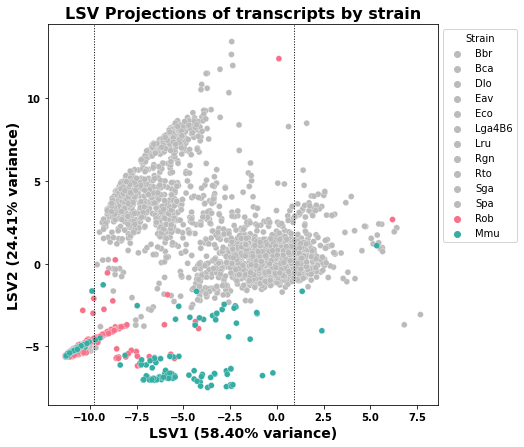

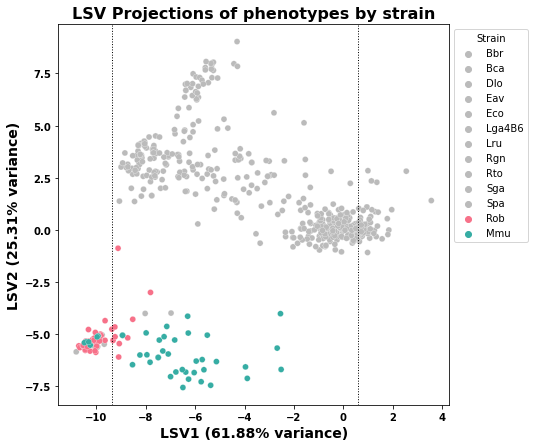

In [117]:
# def LSV_percentile_lines()
ROB_MMU_REST_PALETTE = dict(zip(STRAIN_ABBREVS,["#BBBBBB"]*len(STRAIN_ABBREVS)))
ROB_MMU_REST_PALETTE["Rob"] = "#EB8032"
ROB_MMU_REST_PALETTE["Mmu"] = "#639DF4"

# {"Rob":,"Mmu":,""}

def LSV_percentiles(fp_df,LSV_col="LSV1",percentile=10):
    n_features = len(fp_df)
    n_percentile_features = int(np.ceil(n_features * percentile/100))
    LSV_sorted = fp_df.sort_values(LSV_col)
    bottom, top = LSV_sorted.iloc[0:n_percentile_features,:],LSV_sorted.iloc[-n_percentile_features:]
    return bottom, top 

def LSV_percentile_vlines(fp_df,ax,LSV_col="LSV1",percentile=10):
    bottom_lsv, top_lsv = LSV_percentiles(fp_df,LSV_col,percentile)
    bottom_cutoff = bottom_lsv.iloc[-1][LSV_col]
    top_cutoff = top_lsv.iloc[0][LSV_col]
    ymin,ymax = ax.get_ylim()
    ax.vlines([bottom_cutoff,top_cutoff],ymin,ymax,color='black',linewidth=1,linestyles='dotted')
    ax.set_ylim(ymin,ymax)

def LSV_feature_projections(expr_df,pc_indices,mcseed_df,feature_type="transcript",title_str="",fig_fpath="",
                           partition_strains=[],partition_palette={}):
    if feature_type=="transcript":
        u,s,vh = svd(expr_df)
    elif feature_type=="phenotype":
        u,s,vh = svd(expr_df,full_matrices=True)
    else:
        raise ValueError("feature_type must be 'transcript' or 'phenotype'")
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    feature_projections = sv_projections(expr_df,u,s,vh,axis=1,pc_indices=pc_indices)
    PC_columns = ["LSV{0}".format(pc_idx+1) for pc_idx in pc_indices]
    fp_df = pd.DataFrame(data=feature_projections.T,columns=PC_columns)
    fp_df.set_index(expr_df.columns,inplace=True)
    
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    
    #mcseed annotation of fp_df 
    if feature_type=="transcript":
        mcseed_filt = mcseed_df.loc[mcseed_df.index.isin(fp_df.index),:]
        fp_mcseed_join = fp_df.merge(right=mcseed_filt,left_index=True,right_index=True,sort=True)
        fp_df_mcseed = fp_mcseed_join.loc[fp_df.index,:].drop_duplicates(subset=fp_mcseed_join.columns[:5])
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.loc[:,"Isolate name"].map(STRAIN_TAGS)
    elif feature_type=="phenotype":
        fp_df_mcseed = fp_df.copy()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.index.str.extract("(\w+?)\_[\w\-]+",expand=False)
        fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False) #comaptible with string format phenotypes
#         fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False)
    display(fp_df_mcseed)
    #Solo phenotype LSV Plot
    strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique())) #husl
    strain_palette = ROB_MMU_REST_PALETTE
    
    if len(partition_strains) > 0:
        if len(partition_palette) >0 :
            strain_palette = partition_palette
        else: 
            partition_palette = sns.color_palette("husl",len(partition_strains))
            rest_palette = dict(zip(list(fp_df_mcseed["Strain abbreviation"].unique()),
                                    ["#BBBBBB"]*len(fp_df_mcseed["Strain abbreviation"].unique())))
            strain_palette = rest_palette
            for i,strain in enumerate(partition_strains):
                strain_palette[strain] = partition_palette[i]
        #Use Z-order to prioritize partition
        fp_partition = fp_df_mcseed.loc[fp_df_mcseed["Strain abbreviation"].isin(partition_strains)]
        fp_rest = fp_df_mcseed.loc[~fp_df_mcseed["Strain abbreviation"].isin(partition_strains)]
        sns.scatterplot(data=fp_rest,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25,zorder=0)
        sns.scatterplot(data=fp_partition,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25,zorder=1)
    else:
        strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique()))
        sns.scatterplot(data=fp_df_mcseed,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25)
    xlabel = "{0} ({1}% variance)".format(PC_columns[0],"%.2f" % (expl_variance[0]*100))
    ylabel = "{0} ({1}% variance)".format(PC_columns[1],"%.2f" % (expl_variance[1]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_cols=1,legend_title="Strain")
    
#     bottom_percentile, top_percentile = LSV_percentiles(fp_df_mcseed,LSV_col="LSV{0}".format(pc_indices[0]+1))
    LSV_percentile_vlines(fp_df_mcseed,ax,LSV_col="LSV{0}".format(pc_indices[0]+1))
    if fig_fpath: 
        plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")
        
partition_strains = ["Rob","Mmu"]
# partition_strains = []
ROB_MMU_REST_PALETTE = dict(zip(STRAIN_ABBREVS,["#BBBBBB"]*len(STRAIN_ABBREVS)))
ROB_MMU_REST_PALETTE["Rob"] = "#EB8032"
ROB_MMU_REST_PALETTE["Mmu"] = "#639DF4"
        
title_str = "LSV Projections of transcripts by strain"
fig_fpath = "{0}/LSV_transcript_projections_by_strain.pdf".format(figures_dir)
LSV_feature_projections(bpm_filt_expr_df,pc_indices,mcseed_df,feature_type="transcript",
                       title_str=title_str,fig_fpath=fig_fpath,
                       partition_strains=partition_strains)

title_str = "LSV Projections of phenotypes by strain"
fig_fpath = "{0}/LSV_phenotype_projections_by_strain.pdf".format(figures_dir)
LSV_feature_projections(condensed_agg_expr_df,pc_indices,mcseed_df,feature_type="phenotype",
                       title_str=title_str,fig_fpath=fig_fpath,
                       partition_strains=partition_strains)
        


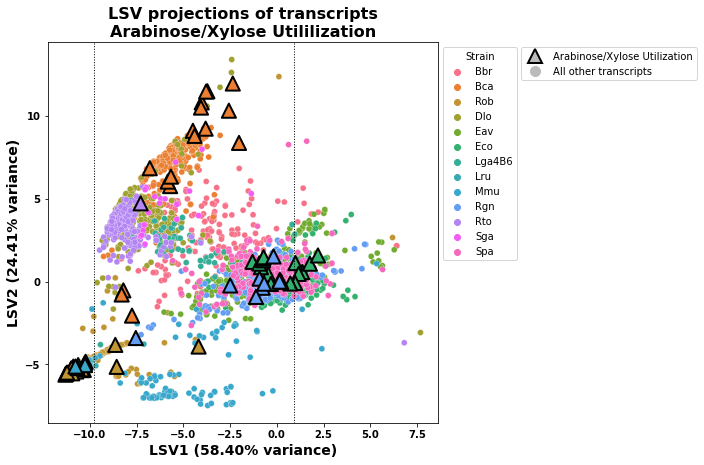

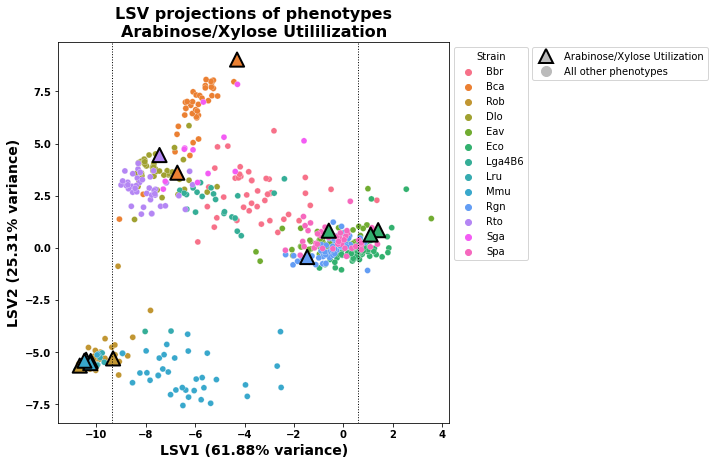

In [118]:


def LSV_feature_projections_partition(expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                                      feature_type="transcript",title_str="",partition_label="",fig_fpath=""):
    #SVD 
    if feature_type=="transcript":
        u,s,vh = svd(expr_df)
    elif feature_type=="phenotype":
        u,s,vh = svd(expr_df,full_matrices=True)
    else:
        raise ValueError("feature_type must be 'transcript' or 'phenotype'")
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    #Feature projections of expr_df 
    feature_projections = sv_projections(expr_df,u,s,vh,axis=1,pc_indices=pc_indices)
    PC_columns = ["LSV{0}".format(pc_idx+1) for pc_idx in pc_indices]
    fp_df = pd.DataFrame(data=feature_projections.T,columns=PC_columns)
    fp_df.set_index(expr_df.columns,inplace=True)
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    #mcseed annotation of fp_df 
    if feature_type=="transcript":
        mcseed_filt = mcseed_df.loc[mcseed_df.index.isin(fp_df.index),:]
        fp_mcseed_join = fp_df.merge(right=mcseed_filt,left_index=True,right_index=True,sort=True)
        fp_df_mcseed = fp_mcseed_join.loc[fp_df.index,:].drop_duplicates(subset=fp_mcseed_join.columns[:5])
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.loc[:,"Isolate name"].map(STRAIN_TAGS)
    elif feature_type=="phenotype":
        fp_df_mcseed = fp_df.copy()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.index.str.extract("(\w+?)\_[\w\-]+",expand=False)
        fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False)
    
    #Deprecated - string version of phenotype lists from mcseed_df  
    #convert list of partition col match values into re, use str.match (for transcripts which may have more than one
    #associated phenotype)
    if(type(fp_df_mcseed["Phenotype"].iloc[0])) == list:
        #TODO: fill me 
        pass
    elif(type(fp_df_mcseed["Phenotype"].iloc[0])) == str:
        match_pattern = '|'.join(partition_values)
        partition_match = fp_df_mcseed.loc[fp_df_mcseed[partition_col].str.match(match_pattern)]
        partition_rest = fp_df_mcseed.loc[~fp_df_mcseed[partition_col].str.match(match_pattern)]
    
#     print(partition_match[partition_col].unique())
    #strain palette in dict format, keyed by abbreviation so partition data points have correct colors 
    strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique()))
    strain_palette = dict(zip(fp_df_mcseed["Strain abbreviation"].unique(),strain_palette))
    #Scatter plot for rest, then matched (triangle, black border, large markers)
    sns.scatterplot(data=partition_rest,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",linewidth=0.25)
    strain_handles,strain_labels = ax.get_legend_handles_labels() #Pass as legend labels later to prevent duplicate entries
    sns.scatterplot(data=partition_match,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",marker="^",edgecolor="#000000",
                    linewidth=2,s=200)
    #Pyplot formatting
    xlabel = "{0} ({1}% variance)".format(PC_columns[0],"%.2f" % (expl_variance[0]*100))
    ylabel = "{0} ({1}% variance)".format(PC_columns[1],"%.2f" % (expl_variance[1]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_cols=1,legend_title="Strain",
                           legend_labels=strain_labels)
    #Partition Legend
    plt.gca().add_artist(ax.get_legend())
    rest_marker = matplotlib.lines.Line2D([],[],color="#BBBBBB",marker="o",linestyle='None',markersize=10,
                                          label="All other {0}s".format(feature_type.lower()))
    if not partition_label:
        partition_label = ", ".join(partition_values)
    partition_marker = matplotlib.lines.Line2D([],[],color="#BBBBBB",marker="^",linestyle='None',
                                               markeredgecolor='black',markeredgewidth=2,
                                               markersize=14,label=partition_label)
    LSV_percentile_vlines(fp_df_mcseed,ax,LSV_col="LSV{0}".format(pc_indices[0]+1))
    ax.legend(handles=[partition_marker,rest_marker])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.2,1))
    #Save figure if fig_path provided 
    if fig_fpath: 
        plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")
    return fig, fp_df_mcseed
#Transcript LSV projections with fermentation partition   
fermentation_phts = ["Propionate","Acetate","Formate"]
# fermentation_phts = ["Propionate"]
fermentation_lactate_phts = ["Propionate","Acetate","Ethanol","L-Lactate","D-Lactate","Lac_ut"]
ara_xyl_phts = ["Ara","Xyl","XOS","aAOS"]
bcaa_glu_phts = ["Glu","Gln","Leu","Val","Ile"]

plot_transcript_partitions = True
if plot_transcript_partitions:
    #Transcript LSV projections with fermentation partition
#     title_str = "LSV projections of transcripts\n Propionate/Acetate/Formate Fermentation"
#     fig_fpath = "{0}/transcript_LSV_fermentation.pdf".format(figures_dir)
#     partition_col = "Phenotype"
#     partition_values = fermentation_phts
#     partition_label = "SCFA Fermentation"
#     fig, fp_tr_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
#                             feature_type="transcript",
#                            title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)

    #Transcript LSV projections with Ara/Xyl partition
    title_str = "LSV projections of transcripts\nArabinose/Xylose Utililization"
    fig_fpath = "{0}/transcript_LSV_AraXyl.pdf".format(figures_dir)
    partition_col = "Phenotype"
    partition_values = ara_xyl_phts
    partition_label = "Arabinose/Xylose Utilization"
    fig, fp_tr_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                            feature_type="transcript",
                           title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)
    
    #Transcript LSV projections with BCAA/Gln partition
#     title_str = "LSV projections of transcripts\nBCAA/Glutamine Utililization"
#     fig_fpath = "{0}/transcript_LSV_BCAA,Gln.pdf".format(figures_dir)
#     partition_col = "Phenotype"
#     partition_values = bcaa_glu_phts
#     partition_label = "BCAA/Glutamine Biosynthesis"
#     fig, fp_tr_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
#                             feature_type="transcript",
#                            title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)
    
plot_phenotype_partitions = True 
if plot_phenotype_partitions:

#     title_str = "LSV projections of phenotypes\nPropionate/Acetate/Formate Fermentation"
#     fig_fpath = "{0}/pht_LSV_fermentation.pdf".format(figures_dir)
#     partition_col = "Phenotype"
#     partition_values = fermentation_phts
#     partition_label = "SCFA Fermentation"
#     fig, fp_pht_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
#                             feature_type="phenotype",
#                            title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)



    title_str = "LSV projections of phenotypes\nArabinose/Xylose Utililization"
    fig_fpath = "{0}/pht_LSV_AraXyl.pdf".format(figures_dir)
    partition_col = "Phenotype"
    partition_values = ara_xyl_phts
    partition_label = "Arabinose/Xylose Utilization"
    fig, fp_pht_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                            feature_type="phenotype",
                           title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)
    
    #Phenotype LSV projections with BCAA/Gln partition
#     title_str = "LSV projections of transcripts\nBCAA/Glutamine Utililization"
#     fig_fpath = "{0}/pht_LSV_BCAA,Gln.pdf".format(figures_dir)
#     partition_col = "Phenotype"
#     partition_values = bcaa_glu_phts
#     partition_label = "BCAA/Glutamine Biosynthesis"
#     fig, fp_pht_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
#                             feature_type="phenotype",
#                            title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)



In [119]:
# display(fp_pht_mcseed)
fp_pht_fpath = "{0}/fp_pht_mcseed.csv".format(fp_tables_dir)
fp_pht_mcseed.to_csv(fp_pht_fpath)

fp_tr_fpath = "{0}/fp_tr_mcseed.csv".format(fp_tables_dir)
fp_tr_mcseed.to_csv(fp_tr_fpath)

# display(fp_tr_mcseed)

In [120]:
##Overall strongest LSV +/- projections: 10th percentile##
print("Top and bottom percentiles of LSV1")
bottom_pht,top_pht = LSV_percentiles(fp_pht_mcseed,LSV_col="LSV1",percentile=10)
bottom_tr,top_tr = LSV_percentiles(fp_tr_mcseed,LSV_col="LSV1",percentile=10)
SHOW_PERCENTILES=False
if SHOW_PERCENTILES:
    display(bottom_pht)
    display(top_pht)

# print("Top and bottom percentiles of LSV2")
# bottom_pht,top_pht = LSV_percentiles(fp_pht_mcseed,LSV_col="LSV2",percentile=10)
# bottom_tr,top_tr = LSV_percentiles(fp_tr_mcseed,LSV_col="LSV2",percentile=10)
# display(bottom_pht)
# display(top_pht)

Top and bottom percentiles of LSV1


/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

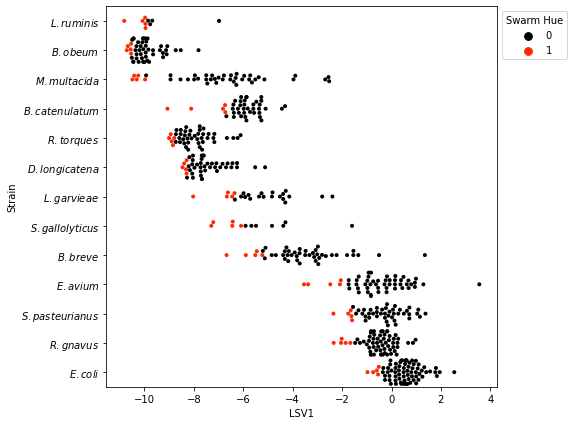

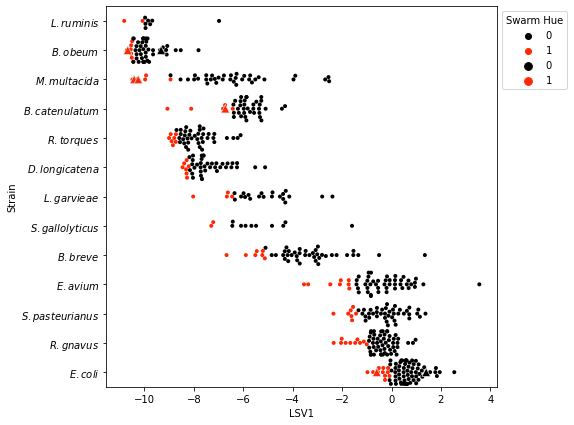

In [131]:
#Strain phenotype swarmplot
def pht_swarmplot(fp_pht_df, swarm_fpath="",palette_style="2hue",emphasized_strains=[],strain_ranking="maxLSV1",
                 pht_cutoff=5,pht_cutoff_type="top",partition_phts=[]):
    """
    @param pht_cutoff: int, either the number or the percentile value of top phenotypes to color
    @param pht_cutoff_type: 'top' or 'percentile,' how pht_cutoff should be used 
    """
    if palette_style == "2hue":
        pht_swarmplot_palette = {0:"#000000",1:"#FF2804"}
    elif palette_style == "4hue":
        assert len(emphasized_strains)>0, "Must provide emphasized_strains for palette_style='4hue'"
#         pht_swarmplot_palette = {0:"#D4D4D4",1:"#FEACA7",2:"#000000",3:"#FF2804"} #og bar/point palette colors
        pht_swarmplot_palette = {0:"#AAAAAA",1:"#F56B66",2:"#000000",3:"#FF2804"}

    fp_swarm_data = fp_pht_df.copy()
    fp_swarm_data.loc[:,"Taxa"] = fp_swarm_data.loc[:,"Strain abbreviation"].map(dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES)))

    strain_lsv_ranking = []
    for strain in fp_swarm_data["Strain abbreviation"].unique():
        strain_swarm_df = fp_swarm_data.loc[fp_swarm_data["Strain abbreviation"]==strain]
        sorted_strain_data = strain_swarm_df.sort_values("LSV1")
        if pht_cutoff_type == 'top':
            sorted_strain_data.loc[:,"pht_cutoff"] = [True]*pht_cutoff+[False]*(len(sorted_strain_data)-pht_cutoff)
        elif pht_cutoff_type == 'percentile':
            percentile_cutoff = int(np.ceil(len(sorted_strain_data)*pht_cutoff*0.01))
            sorted_strain_data.loc[:,"pht_cutoff"] = [True]*percentile_cutoff+[False]*(len(sorted_strain_data)-percentile_cutoff)
        fp_swarm_data.loc[sorted_strain_data.index,"pht_cutoff"] = sorted_strain_data.loc[:,"pht_cutoff"]
        if strain_ranking == "maxLSV1":
            strain_lsv_ranking.append((strain,sorted_strain_data.iloc[0,:]["LSV1"])) #Max LSV1 projection sorting
        elif strain_ranking=="avgLSV1":
            strain_lsv_ranking.append((strain,sorted_strain_data["LSV1"].mean())) #Avg LSV1 projection for sorting

    if palette_style == '2hue':
        fp_swarm_data.loc[:,"Swarm Hue"] = fp_swarm_data["pht_cutoff"].astype(int)
    elif palette_style == '4hue':
        fp_swarm_data.loc[:,"Swarm Hue"] = fp_swarm_data["Strain abbreviation"].isin(emphasized_strains).astype(int)*2 + \
                                            fp_swarm_data["pht_cutoff"].astype(int) #4 hue palette format
    strains_lsv_sorted = sorted(strain_lsv_ranking,key=lambda x:x[1])
    lsv_strain_order = [tup[0] for tup in strains_lsv_sorted]

    ordered_strain_dfs = []
    for strain in lsv_strain_order:
        ordered_strain_dfs.append(fp_swarm_data[fp_swarm_data["Strain abbreviation"]==strain])
    ordered_swarm_data = pd.concat(ordered_strain_dfs)

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    if len(partition_phts) > 0: 
        #partition into matching phts and rest 
        partition_swarm_data = ordered_swarm_data.loc[ordered_swarm_data["Phenotype"].isin(partition_phts)]
        rest_swarm_data = ordered_swarm_data.loc[~ordered_swarm_data["Phenotype"].isin(partition_phts)]
        rest_strains = rest_swarm_data["Strain abbreviation"].unique().tolist()
        #Y_position handling to ensure alignment of strains in partition and rest 
        partition_swarm_data.loc[:,"y_pos"] = partition_swarm_data.loc[:,"Strain abbreviation"].apply(lambda x: rest_strains.index(x))
        sns.scatterplot(data=partition_swarm_data,x="LSV1",y="y_pos",hue="Swarm Hue",
                        palette=pht_swarmplot_palette,marker="^",ax=ax,zorder=1,edgecolor='#DDDDDD',
                       s=70,linewidths=2)
        sns.swarmplot(data=rest_swarm_data,x="LSV1",y="Strain abbreviation",hue="Swarm Hue",palette=pht_swarmplot_palette,
                 size=4,ax=ax,zorder=0) #Plot partition using scatterplot since seaborn doesn't overlay swarmplots well
    else:
        sns.swarmplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",hue="Swarm Hue",palette=pht_swarmplot_palette,
                 size=4)
    ytick_labels = ax.get_yticklabels()
    matched_taxa_labels = [dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES))[label.get_text()] for label in ytick_labels]
    formatted_taxa_labels = ["$\it{0}$".format(label) for label in matched_taxa_labels]
    ax.set_yticklabels(formatted_taxa_labels)
    ax.set_ylabel("Strain")
    # standardize_plot_style(ax,"LSV1 Weight","Strain","")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
    if swarm_fpath:
        plt.savefig(swarm_fpath,dpi=300,facecolor="w",bbox_inches="tight")
    return fig,ordered_swarm_data

swarm_figs_dir = "{0}/swarmplot".format(figures_dir)
if not os.path.exists(swarm_figs_dir):
    os.makedirs(swarm_figs_dir)

emphasized_strains = ["Bca","Rob","Mmu"]
strain_ranking = "maxLSV1"
pht_cutoff_type = "top"
pht_cutoff = 5

palette_style = "2hue"
pht_cutoff_type = "top"
pht_cutoff = 5
# swarm_fpath = "{0}/pht_swarmplot_{1}_{2}_{3}{4}.pdf".format(swarm_figs_dir,palette_style,strain_ranking,
#                                                                pht_cutoff_type,pht_cutoff)
swarm_fpath = "" #don't save
fig, ordered_swarm_data_top5 = pht_swarmplot(fp_pht_mcseed, swarm_fpath,palette_style=palette_style,
                                            emphasized_strains=emphasized_strains,strain_ranking="maxLSV1",
                                             pht_cutoff=pht_cutoff,pht_cutoff_type=pht_cutoff_type)

# palette_style = "2hue"
# pht_cutoff_type = "percentile"
# pht_cutoff = 15
# swarm_fpath = "{0}/pht_swarmplot_{1}_{2}_{3}{4}.pdf".format(swarm_figs_dir,palette_style,strain_ranking,
#                                                                pht_cutoff_type,pht_cutoff)
# fig, ordered_swarm_data_p15 = pht_swarmplot(fp_pht_mcseed, swarm_fpath,palette_style=palette_style,
#                                             emphasized_strains=emphasized_strains,strain_ranking="maxLSV1",
#                                              pht_cutoff=pht_cutoff,pht_cutoff_type=pht_cutoff_type)

palette_style = "2hue"
partition_phts = ["Xyl","Ara"]
partition_tag = "XylAra"
pht_cutoff_type = "percentile"
pht_cutoff = 15
swarm_fpath = "{0}/pht_swarmplot_{1}_{2}_{3}{4}_{5}.pdf".format(swarm_figs_dir,palette_style,strain_ranking,
                                                               pht_cutoff_type,pht_cutoff,partition_tag)
fig, ordered_swarm_data_p15 = pht_swarmplot(fp_pht_mcseed, swarm_fpath,palette_style=palette_style,
                                            emphasized_strains=emphasized_strains,strain_ranking="maxLSV1",
                                             pht_cutoff=pht_cutoff,pht_cutoff_type=pht_cutoff_type,
                                       partition_phts=partition_phts)

/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


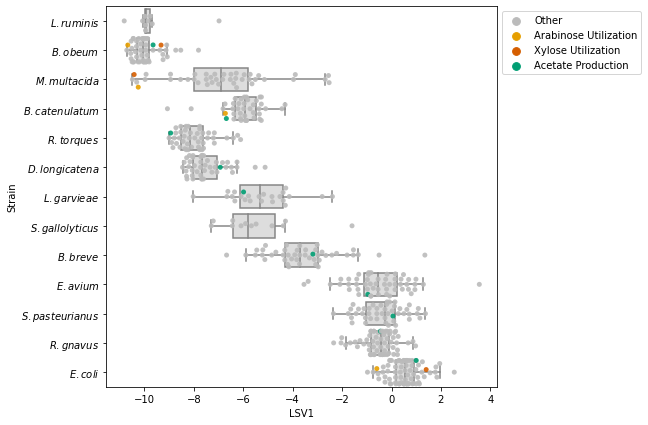

In [136]:
#Strain phenotype swarmplot
def pht_boxplot(fp_pht_df, swarm_fpath="",strain_ranking="maxLSV1",partition_phts=[],swarm_overlay=True,
               swarm_partition_palette={}):
    """
    @param pht_cutoff: int, either the number or the percentile value of top phenotypes to color
    @param pht_cutoff_type: 'top' or 'percentile,' how pht_cutoff should be used 
    """
    if palette_style == "2hue":
        pht_swarmplot_palette = {0:"#000000",1:"#FF2804"}
    elif palette_style == "4hue":
        assert len(emphasized_strains)>0, "Must provide emphasized_strains for palette_style='4hue'"
#         pht_swarmplot_palette = {0:"#D4D4D4",1:"#FEACA7",2:"#000000",3:"#FF2804"} #og bar/point palette colors
        pht_swarmplot_palette = {0:"#AAAAAA",1:"#F56B66",2:"#000000",3:"#FF2804"}

    fp_swarm_data = fp_pht_df.copy()
    fp_swarm_data.loc[:,"Taxa"] = fp_swarm_data.loc[:,"Strain abbreviation"].map(dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES)))

    strain_lsv_ranking = []
    for strain in fp_swarm_data["Strain abbreviation"].unique():
        strain_swarm_df = fp_swarm_data.loc[fp_swarm_data["Strain abbreviation"]==strain]
        sorted_strain_data = strain_swarm_df.sort_values("LSV1")
        if strain_ranking == "maxLSV1":
            strain_lsv_ranking.append((strain,sorted_strain_data.iloc[0,:]["LSV1"])) #Max LSV1 projection sorting
        elif strain_ranking=="avgLSV1":
            strain_lsv_ranking.append((strain,sorted_strain_data["LSV1"].mean())) #Avg LSV1 projection for sorting
    strains_lsv_sorted = sorted(strain_lsv_ranking,key=lambda x:x[1])
    lsv_strain_order = [tup[0] for tup in strains_lsv_sorted]
    ordered_strain_dfs = []
    for strain in lsv_strain_order:
        ordered_strain_dfs.append(fp_swarm_data[fp_swarm_data["Strain abbreviation"]==strain])
    ordered_swarm_data = pd.concat(ordered_strain_dfs)

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    if swarm_overlay:
        sns.boxplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",ax=ax,color="#DDDDDD",zorder=1,fliersize=0)
        if len(partition_phts) > 0:
            def partition_idx_split(pht):
                try:
                    return partition_phts.index(pht)
                except:
                    return -1
            ordered_swarm_data.loc[:,"partition"] = ordered_swarm_data.loc[:,"Phenotype"].apply(partition_idx_split)
            sns.swarmplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",hue="partition",
                          ax=ax,palette=swarm_partition_palette,alpha=0.9,size=5,zorder=2)
        else:
            sns.swarmplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",color="#BBBBBB",
                          ax=ax,alpha=0.9,size=5,zorder=2)
    else:
        sns.boxplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",ax=ax,color="#DDDDDD",zorder=1)
    ytick_labels = ax.get_yticklabels()
    matched_taxa_labels = [dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES))[label.get_text()] for label in ytick_labels]
    formatted_taxa_labels = ["$\it{0}$".format(label) for label in matched_taxa_labels]
    ax.set_yticklabels(formatted_taxa_labels)
    ax.set_ylabel("Strain")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles,["Other"]+[pht_pathway_df.loc[pht,"Functional pathway"] for pht in partition_phts])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
    if swarm_fpath:
        plt.savefig(swarm_fpath,dpi=300,facecolor="w",bbox_inches="tight")
    return fig,ordered_swarm_data

swarm_figs_dir = "{0}/swarmplot".format(figures_dir)
if not os.path.exists(swarm_figs_dir):
    os.makedirs(swarm_figs_dir)

# strain_ranking = "maxLSV1"
# swarm_fpath = "{0}/pht_boxplot_{1}.pdf".format(swarm_figs_dir,strain_ranking)
# fig, _ = pht_boxplot(fp_pht_mcseed, swarm_fpath,strain_ranking="maxLSV1",swarm_overlay=False)

partition_phts = ["Ara","Xyl","Acetate"]
# xyl_ara_palette = {-1:"#BBBBBB",0:"#FA5805",1:"#DE070C",2:"#D905F5"} #Ara, Xyl, Acetate; matching DE grouped 5 hue
xyl_ara_palette = {-1:"#BBBBBB",0:"#E69F00",1:"#D55E00",2:"#009E73"} #Ara, Xyl, Acetate; matched with colorblind 5 hue 
partition_tag = "XylAra"
swarm_fpath = "{0}/pht_boxswarmplot_{1}_{2}_3color.pdf".format(swarm_figs_dir,strain_ranking,partition_tag)
fig, _ = pht_boxplot(fp_pht_mcseed, swarm_fpath,strain_ranking="maxLSV1",
                                       partition_phts=partition_phts,swarm_partition_palette=xyl_ara_palette)

# partition_phts = ["Xyl","XOS","Ara","aAOS","Acetate"]
# xyl_ara_palette = {-1:"#BBBBBB",0:"#EE252C",1:"#F06D70",2:"#006BB7",3:"#3B92CB",4:"#D6AA62"} #Xyl, XOS, Ara,"aAOS" Acetate
# partition_tag = "XylAra_OS"
# swarm_fpath = "{0}/pht_boxswarmplot_{1}_{2}_5color.pdf".format(swarm_figs_dir,strain_ranking,partition_tag)
# fig, _ = pht_boxplot(fp_pht_mcseed, swarm_fpath,strain_ranking="maxLSV1",
#                                        partition_phts=partition_phts,swarm_partition_palette=xyl_ara_palette)

#xyl_ara_palette = {-1:"#BBBBBB",0:"#000000",1:"#000000",2:"#000000",3:"#000000"}
# monocolor_pht_palette = {-1:"#BBBBBB"}
# for i in range(len(partition_phts)):
#     monocolor_pht_palette[i] = "#000000"
# swarm_fpath = "{0}/pht_boxswarmplot_{1}_{2}_binary.pdf".format(swarm_figs_dir,strain_ranking,partition_tag)
# fig, ordered_boxswarm_data = pht_boxplot(fp_pht_mcseed, swarm_fpath,strain_ranking="maxLSV1",
#                                        partition_phts=partition_phts,swarm_partition_palette=monocolor_pht_palette)

/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

,LSV1,LSV2,Strain abbreviation,Phenotype,Taxa,pht_cutoff,Swarm Hue,Functional category,Category Hue
Rob_Glc,-10.713034,-5.557692,Rob,Glc,B. obeum,True,1,Carbohydrate utilization,0.0
Rob_GlcNAc,-9.839202,-4.994080,Rob,GlcNAc,B. obeum,False,0,Carbohydrate utilization,-1.0
Rob_Xyl,-9.325621,-5.295839,Rob,Xyl,B. obeum,False,0,Carbohydrate utilization,-1.0
Rob_Ara,-10.672817,-5.640422,Rob,Ara,B. obeum,True,1,Carbohydrate utilization,0.0
Rob_Fuc,-9.245276,-5.120739,Rob,Fuc,B. obeum,False,0,Carbohydrate utilization,-1.0
...,...,...,...,...,...,...,...,...,...
Eco_BA_t,0.178893,-0.239032,Eco,BA_t,E. coli,False,0,Other catabolic pathways,-1.0
Eco_Lys_d,0.828128,0.030332,Eco,Lys_d,E. coli,False,0,Other catabolic pathways,-1.0
Eco_Pro_d,-0.972975,-0.962195,Eco,Pro_d,E. coli,True,1,Other catabolic pathways,4.0
Eco_Thr_d,1.091159,0.354825,Eco,Thr_d,E. coli,False,0,Other catabolic pathways,-1.0


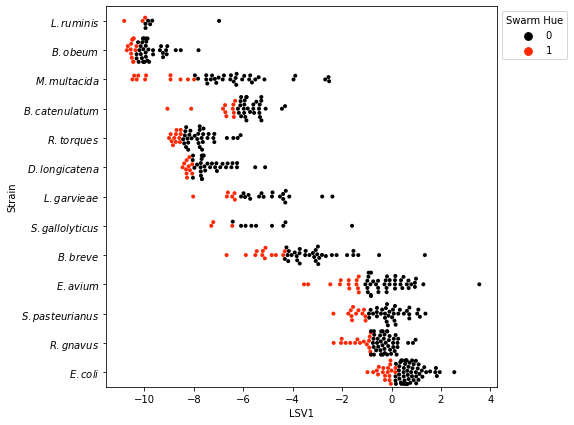

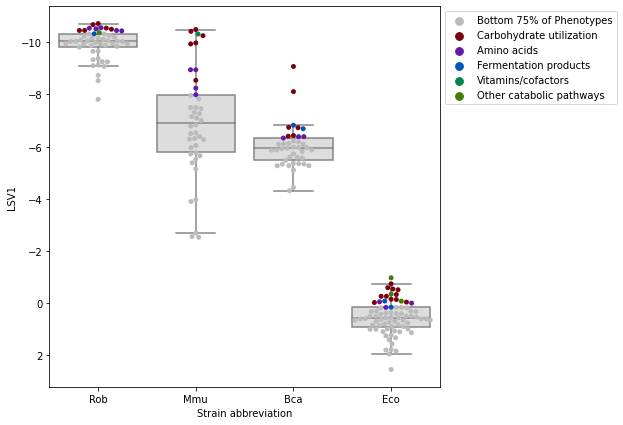

In [133]:
# display(ordered_boxswarm_data)
specific_function_dict ={"Gln":0,"Glu":0,}

func_cat_palette = {-1:"#BBBBBB",0:"#7A010F",1:"#6219A8",2:"#0055BD",3:"#00854D",4:"#437D00"}


XA_strains = ["Rob","Bca","Mmu","Eco"]
# XA_boxswarm = ordered_boxswarm_data.loc[ordered_boxswarm_data["Strain abbreviation"].isin(XA_strains)]
# XA_boxswarm.loc[:,"Functional category"] = XA_boxswarm.loc[:,"Phenotype"].map(pht_pathway_df["Functional category"])

palette_style = "2hue"
pht_cutoff_type = "percentile"
pht_cutoff = 25
swarm_fpath = ""
fig, ordered_swarm_data_p25 = pht_swarmplot(fp_pht_mcseed, swarm_fpath,palette_style=palette_style,
                                            emphasized_strains=emphasized_strains,strain_ranking="maxLSV1",
                                             pht_cutoff=pht_cutoff,pht_cutoff_type=pht_cutoff_type)

XA_p25_annotated = ordered_swarm_data_p25.loc[ordered_swarm_data_p25["Strain abbreviation"].isin(XA_strains)]

XA_p25_annotated.loc[:,"Functional category"] = XA_p25_annotated.loc[:,"Phenotype"].map(pht_pathway_df.loc[:,"Functional category"])

XA_p25_false = XA_p25_annotated.loc[XA_p25_annotated["pht_cutoff"]==False]
XA_p25_annotated.loc[XA_p25_false.index,"Category Hue"] = [-1]*len(XA_p25_false)
XA_p25_true = XA_p25_annotated.loc[XA_p25_annotated["pht_cutoff"]==True]
unique_cats = pht_pathway_df["Functional category"].unique().tolist()

XA_p25_annotated.loc[XA_p25_true.index,"Category Hue"] = XA_p25_true.loc[:,"Functional category"].apply(lambda x: unique_cats.index(x))
display(XA_p25_annotated)

fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.boxplot(data=XA_p25_annotated,x="Strain abbreviation",y="LSV1",color="#DDDDDD",zorder=1,ax=ax,fliersize=0)
sns.swarmplot(data=XA_p25_annotated,x="Strain abbreviation",y="LSV1",hue="Category Hue",palette=func_cat_palette,ax=ax,zorder=2)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymax,ymin)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,["Bottom 75% of Phenotypes"]+unique_cats)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

XA_strain_bs_fpath = "{0}/4strain_top_phts.pdf".format(swarm_figs_dir)
plt.savefig(XA_strain_bs_fpath,dpi=300,facecolor="white",bbox_inches="tight")

In [134]:


ordered_swarm_data = ordered_swarm_data_top5 
top5_phts = ordered_swarm_data.loc[ordered_swarm_data["pht_cutoff"]]
top5_df = pd.DataFrame(index=top5_phts["Strain abbreviation"].unique(),columns=range(1,6))
for strain in top5_phts["Strain abbreviation"].unique():
    strain_top5_phts = top5_phts.loc[top5_phts["Strain abbreviation"]==strain]
    strain_top5_phts.sort_values("LSV1",inplace=True)
    for i in range(5):
        ith_pht = strain_top5_phts.iloc[i]["Phenotype"]
        ith_pathway = pht_pathway_df.loc[ith_pht,"Functional pathway"]
        top5_df.loc[strain,i+1] = ith_pathway
display(top5_df)
top5_df.to_csv("{0}/top5_phts.csv".format(swarm_figs_dir))
#     display()

/var/folders/76/sjjm9lq14pd22nymd3jmmxjh0000gn/T/ipykernel_2969/2326000158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strain_top5_phts.sort_values("LSV1",inplace=True)


,1,2,3,4,5
Lru,Fructose Utilization,"Plp/Pmp Cofactors, De Novo Synthesis",Ethanol Production,Mannose Utilization,Beta-Glucosides Utilization
Rob,Glucose Utilization,Arabinose Utilization,Proline Biosynthesis,Sucrose Utilization,Glutamate Biosynthesis
Mmu,Xylooligosaccharides Utilization,Xylose Utilization,"Plp/Pmp Cofactors, De Novo Synthesis",Arabinose Utilization,Beta-Glucosides Utilization
Bca,Melibiose Utilization,Raffinose Utilization,Formate Production,Lactose Utilization,Arabinose Utilization
Rto,"Cobalamin Cofactors, De Novo Synthesis",Acetate Production,Lactose Utilization,Glutamine Biosynthesis,Proline Biosynthesis
Dlo,N-Acetylneuraminate Utilization,"Plp/Pmp Cofactors, De Novo Synthesis",Alpha-Galactosides Utilization,Threonine Biosynthesis,Lysine Biosynthesis
Lga4B6,N-Acetylmuramic Acid Utilization,Glycine Biosynthesis,"Folate Cofactors, De Novo Synthesis",Lactate Utilization,Lactose Utilization
Sga,Maltose Utilization,Alpha-Galactosides Utilization,Glucoselysine Utilization,Fructoselysine Utilization,Sucrose Utilization
Bbr,Ribose Utilization,Glycine Biosynthesis,N-Acetylneuraminate Utilization,Mannitol Utilization,Histidine Biosynthesis
Eav,N-Acetylmuramic Acid Utilization,Beta-Mannooligosaccharides Utilization,Ethanolamine Utilization,Fructose Utilization,Threonine Degradation


In [125]:
#Ara and Xyl pht, all strains 
ara_xyl_phts = ["Ara","Xyl"]
ara_xyl_os_phts = ["Ara","Xyl","XOS","aAOS"]
display(fp_pht_mcseed[fp_pht_mcseed["Phenotype"].isin(ara_xyl_phts)])
display(fp_pht_mcseed[fp_pht_mcseed["Phenotype"].isin(ara_xyl_os_phts)])
#R. obeum transcripts with Ara/Xyl annotation 
AX_match_pattern = '|'.join(["Ara","Xyl","aAOS","XOS"])
Rob_top3_match = '|'.join(["Xyl","Acetate","Gln"])
Mmu_top3_match = '|'.join(["Ara","Leu","Glu"])

BCAA_match = '|'.join(["Leu","Ile","Val"])
Gln_match = '|'.join(["Gln","Glu"])

#Ara Xyl aAOS XOS 
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Bca")
                     & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
                     & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
                     & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))].sort_values("LSV1"))

#deprecated - E6 cecal 0.3 top 3 phenotype results 
# display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
#                      & (fp_tr_mcseed["Phenotype"].str.contains(Rob_top3_match))].sort_values("LSV1"))
# display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
#                      & (fp_tr_mcseed["Phenotype"].str.contains(Mmu_top3_match))].sort_values("LSV1"))


display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
                     & (fp_tr_mcseed["Phenotype"].str.contains(Gln_match))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
                     & (fp_tr_mcseed["Phenotype"].str.contains(Gln_match))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
                     & (fp_tr_mcseed["Phenotype"].str.contains(BCAA_match))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rto")
                     & (fp_tr_mcseed["Phenotype"].str.contains(BCAA_match))].sort_values("LSV1"))

,LSV1,LSV2,Strain abbreviation,Phenotype
Bca_Ara,-6.724840,3.607282,Bca,Ara
Rob_Xyl,-9.325621,-5.295839,Rob,Xyl
Rob_Ara,-10.672817,-5.640422,Rob,Ara
Eco_Xyl,1.402941,0.852813,Eco,Xyl
Eco_Ara,-0.594896,0.826538,Eco,Ara
Mmu_Xyl,-10.415590,-5.360969,Mmu,Xyl
Mmu_Ara,-10.249825,-5.521789,Mmu,Ara


,LSV1,LSV2,Strain abbreviation,Phenotype
Bca_Ara,-6.724840,3.607282,Bca,Ara
Bca_aAOS,-4.308084,9.029481,Bca,aAOS
Rob_Xyl,-9.325621,-5.295839,Rob,Xyl
Rob_Ara,-10.672817,-5.640422,Rob,Ara
Rob_XOS,-10.231898,-5.422589,Rob,XOS
Eco_Xyl,1.402941,0.852813,Eco,Xyl
Eco_Ara,-0.594896,0.826538,Eco,Ara
Eco_XOS,1.099485,0.643322,Eco,XOS
Mmu_Xyl,-10.415590,-5.360969,Mmu,Xyl
Mmu_Ara,-10.249825,-5.521789,Mmu,Ara


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
NNMNEBCK_00989,-8.297525,-0.780138,Bifidobacterium catenulatum Bgsng468_m22_84,AraH,L-arabinose transport system permease protein ...,Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_00988,-8.205529,-0.531131,Bifidobacterium catenulatum Bgsng468_m22_84,AraG,L-arabinose transport ATP-binding protein AraG...,Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_00987,-7.744524,-2.055067,Bifidobacterium catenulatum Bgsng468_m22_84,AraF,L-arabinose-binding periplasmic protein precur...,Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_00986,-6.792700,6.852012,Bifidobacterium catenulatum Bgsng468_m22_84,AraU,Predicted transcriptional regulator of arabino...,Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_01776,-5.832880,6.042318,Bifidobacterium catenulatum Bgsng468_m22_84,AraD,L-ribulose-5-phosphate 4-epimerase (EC 5.1.3.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Bca
NNMNEBCK_01775,-5.705920,5.772013,Bifidobacterium catenulatum Bgsng468_m22_84,AraA,L-arabinose isomerase (EC 5.3.1.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Bca
NNMNEBCK_01777,-5.664135,6.343298,Bifidobacterium catenulatum Bgsng468_m22_84,AraB,Ribulokinase (EC 2.7.1.16),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Bca
NNMNEBCK_01778,-4.486243,9.112832,Bifidobacterium catenulatum Bgsng468_m22_84,AraQ_LacI,"AraQ transcriptional regulator, LacI family",Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_00010,-4.397053,8.806428,Bifidobacterium catenulatum Bgsng468_m22_84,AbfB,Double substituted xylan alpha-(1->3)-L-arabin...,Carbohydrate utilization,alpha-arabinooligosaccharides utilization,aAOS,Bca
NNMNEBCK_00319,-4.053298,10.515060,Bifidobacterium catenulatum Bgsng468_m22_84,AauC,Predicted alpha-arabino-oligosaccharides ABC t...,Carbohydrate utilization,alpha-arabinooligosaccharides utilization,aAOS,Bca


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
HIAFFLEM_01096,-11.300774,-5.625606,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01075,-11.285557,-5.570476,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_02456,-11.254835,-5.570747,Blautia obeum Bg7063_SSTS2015,AraA,L-arabinose isomerase (EC 5.3.1.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Rob
HIAFFLEM_02458,-11.218916,-5.496731,Blautia obeum Bg7063_SSTS2015,AraD,L-ribulose-5-phosphate 4-epimerase (EC 5.1.3.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Rob
HIAFFLEM_02453,-11.005243,-5.269542,Blautia obeum Bg7063_SSTS2015,AraX,"Predicted L-arabinose ABC transport system, AT...",Carbohydrate utilization,arabinose utilization,Ara,Rob
HIAFFLEM_02455,-10.982050,-5.239296,Blautia obeum Bg7063_SSTS2015,AraZ,"Predicted L-arabinose ABC transport system, pe...",Carbohydrate utilization,arabinose utilization,Ara,Rob
HIAFFLEM_02457,-10.937390,-5.542664,Blautia obeum Bg7063_SSTS2015,AraB,Ribulokinase (EC 2.7.1.16),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Rob
HIAFFLEM_02454,-10.881943,-5.136003,Blautia obeum Bg7063_SSTS2015,AraY,"Predicted L-arabinose ABC transport system, pe...",Carbohydrate utilization,arabinose utilization,Ara,Rob
HIAFFLEM_02425,-10.729437,-5.433987,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_02452,-10.414965,-5.298519,Blautia obeum Bg7063_SSTS2015,AraW,"Predicted L-arabinose ABC transport system, pe...",Carbohydrate utilization,arabinose utilization,Ara,Rob


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ONMCJBAG_01615,-10.768821,-5.131641,Mitsuokella multacida DSM_20544,XynB,Beta-xylosidase (EC 3.2.1.37),Carbohydrate utilization,xylooligosaccharides utilization,XOS,Mmu
ONMCJBAG_00857,-10.663138,-5.222382,Mitsuokella multacida DSM_20544,AraA,L-arabinose isomerase (EC 5.3.1.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Mmu
ONMCJBAG_01925,-10.624700,-5.043270,Mitsuokella multacida DSM_20544,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Mmu
ONMCJBAG_00859,-10.254260,-5.044683,Mitsuokella multacida DSM_20544,AraB,Ribulokinase (EC 2.7.1.16),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Mmu


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
HIAFFLEM_03118,-11.199097,-5.434561,Blautia obeum Bg7063_SSTS2015,GltB,Glutamate synthase [NADPH] large chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Rob
HIAFFLEM_00723,-11.042176,-5.502842,Blautia obeum Bg7063_SSTS2015,GlnN,"Glutamine synthetase type III, GlnN (EC 6.3.1.2)",Amino acids,glutamine biosynthesis,Gln,Rob
HIAFFLEM_03169,-11.026453,-5.436690,Blautia obeum Bg7063_SSTS2015,GltD,Glutamate synthase [NADPH] small chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Rob
HIAFFLEM_00410,-10.979176,-5.501645,Blautia obeum Bg7063_SSTS2015,Gdh1,NADP-specific glutamate dehydrogenase (EC 1.4....,Amino acids,glutamate biosynthesis,Glu,Rob
HIAFFLEM_03119,-10.421006,-4.926355,Blautia obeum Bg7063_SSTS2015,GltD,Glutamate synthase [NADPH] small chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Rob
HIAFFLEM_03125,-10.313161,-4.883446,Blautia obeum Bg7063_SSTS2015,GatB,Aspartyl-tRNA(Asn) amidotransferase subunit B ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Rob
HIAFFLEM_03125,-10.313161,-4.883446,Blautia obeum Bg7063_SSTS2015,GatB,Glutamyl-tRNA(Gln) amidotransferase subunit B ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Rob
HIAFFLEM_03124,-10.307367,-4.921969,Blautia obeum Bg7063_SSTS2015,GatA,Aspartyl-tRNA(Asn) amidotransferase subunit A ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Rob
HIAFFLEM_03124,-10.307367,-4.921969,Blautia obeum Bg7063_SSTS2015,GatA,Glutamyl-tRNA(Gln) amidotransferase subunit A ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Rob
HIAFFLEM_01314,-10.085161,-4.788879,Blautia obeum Bg7063_SSTS2015,GltB,Glutamate synthase [NADPH] large chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Rob


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ONMCJBAG_01809,-10.971131,-5.337340,Mitsuokella multacida DSM_20544,GatA,Aspartyl-tRNA(Asn) amidotransferase subunit A ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Mmu
ONMCJBAG_01809,-10.971131,-5.337340,Mitsuokella multacida DSM_20544,GatA,Glutamyl-tRNA(Gln) amidotransferase subunit A ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Mmu
ONMCJBAG_00883,-10.959693,-5.354390,Mitsuokella multacida DSM_20544,GltB,Glutamate synthase [NADPH] large chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Mmu
ONMCJBAG_00882,-6.660863,-6.297601,Mitsuokella multacida DSM_20544,GltD,Glutamate synthase [NADPH] small chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Mmu
ONMCJBAG_00079,-4.264387,-7.103950,Mitsuokella multacida DSM_20544,GlnA6,"Glutamine synthetase, clostridia type (EC 6.3....",Amino acids,glutamine biosynthesis,Gln,Mmu
ONMCJBAG_00446,-3.208346,-3.003182,Mitsuokella multacida DSM_20544,Gdh1,NADP-specific glutamate dehydrogenase (EC 1.4....,Amino acids,glutamate biosynthesis,Glu,Mmu
ONMCJBAG_01810,-2.423959,-7.403649,Mitsuokella multacida DSM_20544,GatB,Aspartyl-tRNA(Asn) amidotransferase subunit B ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Mmu
ONMCJBAG_01810,-2.423959,-7.403649,Mitsuokella multacida DSM_20544,GatB,Glutamyl-tRNA(Gln) amidotransferase subunit B ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Mmu


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ONMCJBAG_01767,-11.207339,-5.476205,Mitsuokella multacida DSM_20544,LeuC,3-isopropylmalate dehydratase large subunit (E...,Amino acids,leucine biosynthesis,Leu,Mmu
ONMCJBAG_01954,-11.190830,-5.556193,Mitsuokella multacida DSM_20544,IlvE,Branched-chain amino acid aminotransferase (EC...,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01769,-11.165033,-5.429706,Mitsuokella multacida DSM_20544,LeuB,3-isopropylmalate dehydrogenase (EC 1.1.1.85),Amino acids,leucine biosynthesis,Leu,Mmu
ONMCJBAG_02049,-11.018873,-5.361079,Mitsuokella multacida DSM_20544,IlvD,Dihydroxy-acid dehydratase (EC 4.2.1.9),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01337,-11.002488,-5.305739,Mitsuokella multacida DSM_20544,IlvA,Threonine dehydratase (EC 4.3.1.19),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_00607,-10.849646,-5.263800,Mitsuokella multacida DSM_20544,IlvM,Acetolactate synthase small subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01768,-10.368476,-4.908554,Mitsuokella multacida DSM_20544,LeuD,3-isopropylmalate dehydratase small subunit (E...,Amino acids,leucine biosynthesis,Leu,Mmu
ONMCJBAG_00732,-10.304790,-4.925032,Mitsuokella multacida DSM_20544,LivF,Branched-chain amino acid transport ATP-bindin...,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_00736,-6.911969,-6.846980,Mitsuokella multacida DSM_20544,LivB,"Branched-chain amino acid ABC transporter, ami...",Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01770,-6.438242,-6.957821,Mitsuokella multacida DSM_20544,IlvG,Acetolactate synthase large subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
CGCJBKJN_00614,-9.062745,3.000530,Ruminococcus torques Bg7063,LeuC,3-isopropylmalate dehydratase large subunit (E...,Amino acids,leucine biosynthesis,Leu,Rto
CGCJBKJN_00616,-8.963315,3.331788,Ruminococcus torques Bg7063,LeuC,3-isopropylmalate dehydratase large subunit (E...,Amino acids,leucine biosynthesis,Leu,Rto
CGCJBKJN_01437,-8.663547,3.871159,Ruminococcus torques Bg7063,IlvA,Threonine dehydratase (EC 4.3.1.19),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_01243,-8.519009,4.395808,Ruminococcus torques Bg7063,IlvG,Acetolactate synthase large subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_01309,-8.489067,4.215097,Ruminococcus torques Bg7063,IlvC; IlvC2,Ketol-acid reductoisomerase (NADP(+)) (EC 1.1....,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_00615,-8.448634,3.065630,Ruminococcus torques Bg7063,LeuD,3-isopropylmalate dehydratase small subunit (E...,Amino acids,leucine biosynthesis,Leu,Rto
CGCJBKJN_01244,-8.382044,4.538936,Ruminococcus torques Bg7063,IlvD,Dihydroxy-acid dehydratase (EC 4.2.1.9),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_02929,-8.322762,4.104448,Ruminococcus torques Bg7063,IlvE,Branched-chain amino acid aminotransferase (EC...,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_00455,-8.289944,2.658864,Ruminococcus torques Bg7063,IlvG,Acetolactate synthase large subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_01746,-7.997915,2.884107,Ruminococcus torques Bg7063,LivM,Branched-chain amino acid transport system per...,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto


In [126]:
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
                     & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))])

,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
HIAFFLEM_01075,-11.285557,-5.570476,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01096,-11.300774,-5.625606,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01102,-10.224270,-4.843486,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01301,-10.322503,-5.333024,Blautia obeum Bg7063_SSTS2015,XylH,"Xylose ABC transporter, permease protein XylH",Carbohydrate utilization,xylose utilization,Xyl,Rob
HIAFFLEM_01302,-8.563692,-5.151394,Blautia obeum Bg7063_SSTS2015,XylG,D-xylose transport ATP-binding protein XylG,Carbohydrate utilization,xylose utilization,Xyl,Rob
HIAFFLEM_01303,-4.181170,-3.925802,Blautia obeum Bg7063_SSTS2015,XylF,"Xylose ABC transporter, periplasmic xylose-bin...",Carbohydrate utilization,xylose utilization,Xyl,Rob
HIAFFLEM_01966,-8.635897,-3.823712,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_02424,-10.390312,-5.351053,Blautia obeum Bg7063_SSTS2015,XylA2,predicted xylose isomerase,Carbohydrate utilization,xylose utilization; xylooligosaccharides utili...,Xyl; XOS,Rob
HIAFFLEM_02425,-10.729437,-5.433987,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01073,-10.272108,-4.927934,Blautia obeum Bg7063_SSTS2015,AraD,L-ribulose-5-phosphate 4-epimerase (EC 5.1.3.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Rob


In [127]:
#TODO: bacteria by bacteria LSV projections 
# Bbr, Bca, Rob, ...  
#Eav, Eco; 

if not os.path.exists(lsv_tables_dir):
    os.makedirs(lsv_tables_dir)
# for strain in ["Bbr","Bca","Rob","Eav","Eco","Rgn","Mmu"]:
for strain in fp_pht_mcseed["Strain abbreviation"].unique():
    strain_fp = fp_pht_mcseed.loc[fp_pht_mcseed["Strain abbreviation"]==strain]
    strain_fp = strain_fp.sort_values("LSV1")#sort by LSV1
    display(strain_fp)
    strain_fpath = "{0}/{1}_LSV.csv".format(lsv_tables_dir,strain)
    strain_fp.to_csv(strain_fpath)
    

,LSV1,LSV2,Strain abbreviation,Phenotype
Bbr_Rbs,-6.674952,3.610726,Bbr,Rbs
Bbr_Gly,-5.895567,0.286571,Bbr,Gly
Bbr_NANA,-5.510711,1.980242,Bbr,NANA
Bbr_Mtl,-5.453059,2.918909,Bbr,Mtl
Bbr_His,-5.229260,0.996644,Bbr,His
Bbr_B9,-5.206937,3.826928,Bbr,B9
Bbr_B1,-5.126133,1.442080,Bbr,B1
Bbr_Ser,-5.098859,4.844155,Bbr,Ser
Bbr_Lac,-4.848155,2.437635,Bbr,Lac
Bbr_Raf,-4.680162,4.881256,Bbr,Raf


,LSV1,LSV2,Strain abbreviation,Phenotype
Bca_Mel,-9.068876,1.381729,Bca,Mel
Bca_Raf,-8.106780,2.570701,Bca,Raf
Bca_Formate,-6.817756,4.608574,Bca,Formate
Bca_Lac,-6.737093,5.446920,Bca,Lac
Bca_Ara,-6.724840,3.607282,Bca,Ara
Bca_Acetate,-6.684089,5.829520,Bca,Acetate
Bca_Glc,-6.424520,6.369983,Bca,Glc
Bca_Fru,-6.398545,6.982416,Bca,Fru
Bca_Val,-6.380028,6.691883,Bca,Val
Bca_Ile,-6.380028,6.691883,Bca,Ile


,LSV1,LSV2,Strain abbreviation,Phenotype
Rob_Glc,-10.713034,-5.557692,Rob,Glc
Rob_Ara,-10.672817,-5.640422,Rob,Ara
Rob_Pro,-10.553869,-5.537046,Rob,Pro
Rob_Scr,-10.538565,-5.538794,Rob,Scr
Rob_Glu,-10.537023,-5.535946,Rob,Glu
Rob_Ser,-10.510319,-5.469060,Rob,Ser
Rob_Rbs,-10.496073,-5.614263,Rob,Rbs
Rob_Chb,-10.451603,-5.772811,Rob,Chb
Rob_Lys,-10.448786,-5.461047,Rob,Lys
Rob_Lnb,-10.448783,-5.750021,Rob,Lnb


,LSV1,LSV2,Strain abbreviation,Phenotype
Dlo_NANA,-8.456786,1.364815,Dlo,NANA
Dlo_B6,-8.390715,3.567209,Dlo,B6
Dlo_Aga,-8.316223,2.943992,Dlo,Aga
Dlo_Thr,-8.294530,4.086452,Dlo,Thr
Dlo_Lys,-8.290184,4.039802,Dlo,Lys
Dlo_Thr_d,-8.276484,3.181271,Dlo,Thr_d
Dlo_Glc,-8.207034,4.143650,Dlo,Glc
Dlo_Lac,-8.178886,3.594632,Dlo,Lac
Dlo_Fru,-8.157364,3.459739,Dlo,Fru
Dlo_Val,-8.065198,4.250138,Dlo,Val


,LSV1,LSV2,Strain abbreviation,Phenotype
Eav_MurNac,-3.541318,-0.186439,Eav,MurNac
Eav_bMnOS,-3.373907,-0.634357,Eav,bMnOS
Eav_EA_ut,-2.477659,0.932856,Eav,EA_ut
Eav_Fru,-2.086302,-0.082018,Eav,Fru
Eav_Thr_d,-2.051784,-0.366347,Eav,Thr_d
Eav_Gtl,-1.734967,0.072980,Eav,Gtl
Eav_PD_ut,-1.730484,0.943044,Eav,PD_ut
Eav_Rhi,-1.708331,0.043813,Eav,Rhi
Eav_Man,-1.416718,-0.300371,Eav,Man
Eav_Bgl,-1.406046,-0.072683,Eav,Bgl


,LSV1,LSV2,Strain abbreviation,Phenotype
Eco_Pro_d,-0.972975,-0.962195,Eco,Pro_d
Eco_ddGlcA,-0.743543,-0.798328,Eco,ddGlcA
Eco_Ara,-0.594896,0.826538,Eco,Ara
Eco_GlcAs,-0.545231,-0.550502,Eco,GlcAs
Eco_NANA,-0.515296,-0.197591,Eco,NANA
...,...,...,...,...
Eco_Scr,1.773012,0.538817,Eco,Scr
Eco_B1,1.797768,-0.220786,Eco,B1
Eco_Fru,1.836278,-0.002714,Eco,Fru
Eco_Mel,1.952093,0.969875,Eco,Mel


,LSV1,LSV2,Strain abbreviation,Phenotype
Lga4B6_MurNac,-8.027540,-4.003581,Lga4B6,MurNac
Lga4B6_Gly,-6.663326,3.501340,Lga4B6,Gly
Lga4B6_B9,-6.622447,2.765174,Lga4B6,B9
Lga4B6_Lac_ut,-6.449545,2.625410,Lga4B6,Lac_ut
Lga4B6_Lac,-6.353197,2.559340,Lga4B6,Lac
Lga4B6_Glc,-6.340011,1.856385,Lga4B6,Glc
Lga4B6_Chor,-6.088113,2.877573,Lga4B6,Chor
Lga4B6_Acetate,-5.987455,1.716380,Lga4B6,Acetate
Lga4B6_Fru,-5.927216,2.671678,Lga4B6,Fru
Lga4B6_Cys,-5.786086,3.130442,Lga4B6,Cys


,LSV1,LSV2,Strain abbreviation,Phenotype
Lru_Fru,-10.817458,-5.844433,Lru,Fru
Lru_B6,-10.074221,-5.592319,Lru,B6
Lru_Ethanol,-9.972353,-5.624705,Lru,Ethanol
Lru_Man,-9.957344,-5.599464,Lru,Man
Lru_Bgl,-9.955064,-5.598124,Lru,Bgl
Lru_Glu,-9.851303,-5.255012,Lru,Glu
Lru_Glc,-9.767754,-5.034442,Lru,Glc
Lru_Formate,-9.683433,-5.478362,Lru,Formate
Lru_L-Lactate,-6.979694,-3.984688,Lru,L-Lactate


,LSV1,LSV2,Strain abbreviation,Phenotype
Mmu_XOS,-10.485293,-5.405630,Mmu,XOS
Mmu_Xyl,-10.415590,-5.360969,Mmu,Xyl
Mmu_B6,-10.311545,-5.367574,Mmu,B6
Mmu_Ara,-10.249825,-5.521789,Mmu,Ara
Mmu_Bgl,-9.971569,-5.129640,Mmu,Bgl
Mmu_Rbs,-9.932567,-5.090639,Mmu,Rbs
Mmu_Phe,-8.942965,-5.051515,Mmu,Phe
Mmu_Tyr,-8.942965,-5.051515,Mmu,Tyr
Mmu_Srl,-8.538888,-6.462045,Mmu,Srl
Mmu_Leu,-8.238509,-5.995890,Mmu,Leu


,LSV1,LSV2,Strain abbreviation,Phenotype
Rgn_Mel,-2.341626,-0.320662,Rgn,Mel
Rgn_Lac,-2.042909,-0.811078,Rgn,Lac
Rgn_Fcs,-2.015475,-0.374178,Rgn,Fcs
Rgn_GOS,-1.857629,-0.639748,Rgn,GOS
Rgn_Rhi,-1.669316,-0.481504,Rgn,Rhi
...,...,...,...,...
Rgn_Ile,0.241477,0.577716,Rgn,Ile
Rgn_Met,0.270314,0.161402,Rgn,Met
Rgn_Cys,0.672736,0.475070,Rgn,Cys
Rgn_Mal,0.867492,0.270292,Rgn,Mal


,LSV1,LSV2,Strain abbreviation,Phenotype
Rto_B12,-9.003039,3.016059,Rto,B12
Rto_Acetate,-8.937834,3.210125,Rto,Acetate
Rto_Lac,-8.899862,3.117748,Rto,Lac
Rto_Gln,-8.846457,3.689605,Rto,Gln
Rto_Pro,-8.791475,2.991349,Rto,Pro
Rto_Lys,-8.731354,3.147067,Rto,Lys
Rto_Asn,-8.725083,3.025302,Rto,Asn
Rto_Gly,-8.700753,2.837396,Rto,Gly
Rto_GlcNAc,-8.587112,1.997238,Rto,GlcNAc
Rto_FruLys,-8.561355,2.953438,Rto,FruLys


,LSV1,LSV2,Strain abbreviation,Phenotype
Sga_Mal,-7.293225,2.819206,Sga,Mal
Sga_Aga,-7.214190,3.190150,Sga,Aga
Sga_GlcLys,-6.442753,4.733051,Sga,GlcLys
Sga_FruLys,-6.425224,4.785859,Sga,FruLys
Sga_Scr,-6.089696,4.702048,Sga,Scr
Sga_Fru,-5.906081,3.137091,Sga,Fru
Sga_Man,-5.671701,6.993942,Sga,Man
Sga_Ethanol,-5.481190,3.567402,Sga,Ethanol
Sga_L-Lactate,-4.836666,5.308764,Sga,L-Lactate
Sga_Formate,-4.380843,3.662163,Sga,Formate


,LSV1,LSV2,Strain abbreviation,Phenotype
Spa_bMnOS,-2.350959,-0.110229,Spa,bMnOS
Spa_Ino,-1.751041,-0.349577,Spa,Ino
Spa_ManNAc,-1.650121,0.308472,Spa,ManNAc
Spa_Aga,-1.620223,1.503586,Spa,Aga
Spa_Bgl,-1.595463,0.067959,Spa,Bgl
Spa_Ethanol,-1.556145,1.066407,Spa,Ethanol
Spa_Tre,-1.434484,0.832154,Spa,Tre
Spa_His,-1.336131,1.198813,Spa,His
Spa_Man,-1.177865,0.001924,Spa,Man
Spa_Glc,-1.114012,0.218042,Spa,Glc


In [42]:
# display(fp_pht_mcseed[fp_pht_mcseed["Phenotype"].isin(["Ara","Xyl"])])

,LSV1,LSV2,Strain abbreviation,Phenotype,Functional category
Bbr_Glc,-2.657310,1.366979,Bbr,Glc,Carbohydrate utilization
Bbr_Fru,-4.277768,1.596130,Bbr,Fru,Carbohydrate utilization
Bbr_NANA,-6.766172,2.176520,Bbr,NANA,Carbohydrate utilization
Bbr_Fuc,-1.017714,2.846611,Bbr,Fuc,Carbohydrate utilization
Bbr_Mal,-3.710901,2.598251,Bbr,Mal,Carbohydrate utilization
...,...,...,...,...,...
Spa_Acetate,0.111708,-0.107250,Spa,Acetate,Fermentation products
Spa_Formate,0.161850,0.827331,Spa,Formate,Fermentation products
Spa_L-Lactate,0.649765,0.598215,Spa,L-Lactate,Fermentation products
Spa_Ethanol,-1.836959,1.101655,Spa,Ethanol,Fermentation products


ValueError: The palette list has the wrong number of colors.

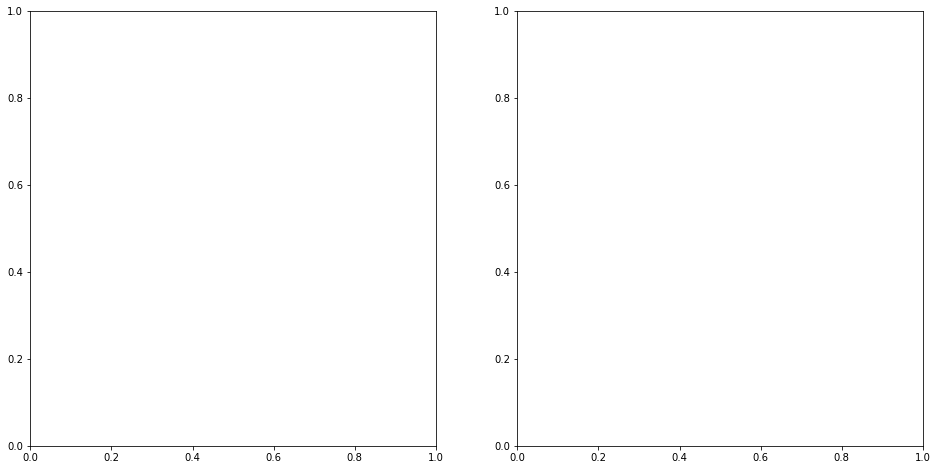

In [43]:
#Mapping pathways back to functional categories 
#Use mcseed_df (without list version phenotypes) for list of phenotype unique values 
pht_fc_dict = {}
for pht_str in mcseed_df["Phenotype"].unique(): #pht_str is a variable length semicolon separated string of different phenotypes
    pht_list = pht_str.split(";") 
    pht_str_rows = mcseed_df.loc[mcseed_df["Phenotype"]==pht_str,:]
    assert(len(pht_str_rows["Functional category"].unique()) == 1)
    fc_cat_str = pht_str_rows["Functional category"].iloc[0]
    fc_cat_list = fc_cat_str.split(";")
    for i,pht in enumerate(pht_list):
        if pht not in pht_fc_dict:
            if len(fc_cat_list) == 1: #If only one functional category for all entries in pht_str, use that category
                pht_fc_dict[pht] = fc_cat_list[0]
            elif len(fc_cat_list) == len(pht_list): #If one-to-one mapping of phenotypes to functional categories, go in order
                pht_fc_dict[pht] = fc_cat_list[i]
            else: #Not one-to-one mapping of phenotypes to functional categories; use some HARD CODING TM  
                print(pht_str)
                print(fc_cat_str)
                raise ValueError("Cannot automatically match phenotypes to functional categories based on prior entries")

fp_pht_mcseed.loc[:,"Functional category"] = fp_pht_mcseed["Phenotype"].map(pht_fc_dict)
display(fp_pht_mcseed)

n_fc_unique = len(fp_pht_mcseed["Functional category"].unique())
# fc_palette = sns.color_palette("husl", n_fc_unique)
fc_palette = sns.color_palette("Set2")[:n_fc_unique]
fig,axes = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = axes
#Strain phenotypes by functional category
strain_palette = sns.color_palette("husl", len(fp_pht_mcseed["Strain abbreviation"].unique()))
sns.scatterplot(data=fp_pht_mcseed,x="LSV1",y="LSV2",ax=ax1,
                palette=fc_palette,hue="Functional category")
handles,labels = ax1.get_legend_handles_labels()
ax1.legend(handles,labels,loc="best")
ax1.set_title("LSV Projections of strain phenotypes by functional category")
#Strain phenotypes by strain
sns.scatterplot(data=fp_pht_mcseed,x="LSV1",y="LSV2",ax=ax2,
                palette=strain_palette,hue="Strain abbreviation")
handles,labels = ax2.get_legend_handles_labels()
ax2.legend(handles,labels,loc="best",ncol=2)
ax2.set_title("LSV Projections of strain phenotypes by strain")
plt.savefig("{0}/feature_projections_SVD.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")

plt.savefig("{0}/phenotypes_functionalcategory_SVD.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")


In [ ]:
#SVD Feature Comparison 
u_tr,s_tr,vh_tr = svd(bpm_filt_log_df)
u_pht,s_pht,vh_pht = svd(condensed_agg_log_df,full_matrices=True)

#Explained variance calculated from s -> eigenvalues 
eigenvalues_tr = s_tr**2/(len(s_tr)-1)
expl_variance_tr = eigenvalues_tr / np.sum(eigenvalues_tr)
eigenvalues_pht = s_pht**2/(len(s_pht)-1)
expl_variance_pht = eigenvalues_pht / np.sum(eigenvalues_pht)

n_SV = 2
print("Explained Variance (Transcripts, first {0}): {1}".format(n_SV,expl_variance_tr[:n_SV]))
print("Explained Variance (Phenotype, first {0}): {1}".format(n_SV,expl_variance_pht[:n_SV]))

LSV1_tr = u_tr[:,0]
RSV1_tr = vh_tr[0,:]

print("LSV1 Transcript")
print(LSV1_tr)
print("RSV1 Transcript")
print(RSV1_tr)

LSV1_pht = u_pht[:,0]
RSV1_pht = vh_pht[0,:]

tr_10th, tr_90th = np.percentile(RSV1_tr,[10,90])
print(tr_10th,tr_90th)
pht_10th, pht_90th = np.percentile(RSV1_pht,[10,90])
print(pht_10th,pht_90th)
hist_color = sns.color_palette("Set2")[2]
vline_color = sns.color_palette("Set2")[7]
#Subplots and axes set up, grids, titles, x_labels with PC
fig,axes = plt.subplots(2,1,figsize=(8,10))
ax1,ax2 = axes
for ax in [ax1,ax2]:
    ax.grid(visible=True,color="white")
    ax.set_axisbelow(True)
    ax.set_facecolor("#EBEAF2")
    ax.set_ylabel("Counts")
ax1.set_title("Transcript Projections onto Transcript LSV1")
ax1.set_xlabel("LSV{0} ({1}% variance)".format(pc_indices[0]+1,
                                              "%.2f" % (expl_variance_tr[pc_indices[0]]*100)))
ax2.set_title("Strain Phenotype Projections onto Strain LSV1")
ax2.set_xlabel("LSV{0} ({1}% variance)".format(pc_indices[0]+1,
                                              "%.2f" % (expl_variance_pht[pc_indices[0]]*100)))
#Histogram and vline plotting for histogram 10th and 90th percentiles 
ax1.hist(RSV1_tr.flatten(),bins=25,color=hist_color)
ax1_ylim = ax1.get_ylim()
ax1.vlines([tr_10th,tr_90th],*ax1.get_ylim(),color=vline_color,linewidth=1.5)
ax1.set_ylim(ax1_ylim) #without this line vlines resets ylims for some reason - specific to using hist 
ax2.hist(RSV1_pht.flatten(),bins=25,color=hist_color)
ax2_ylim = ax2.get_ylim()
ax2.vlines([pht_10th,pht_90th],*ax2.get_ylim(),color=vline_color,linewidth=1.5)
ax2.set_ylim(ax2_ylim)

plt.savefig("{0}/LSV1_projection_histogram.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")